In [ ]:
!pip install statsmodels
!pip install pymannkendall
!pip install matplotlib 
!pip install seaborn
!pip install scikit-learn

In [272]:
import pandas as pd 
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import pymannkendall as mk
import seaborn as sns
import scipy.stats as stats
from sklearn.cluster import DBSCAN

### Tache 1  Chargment et exploration des donnees + Nettoyage : 

In [273]:
### Chargement des données
data_frame = pd.read_excel('./REGLEMENTS_CARTES_PREPAYEES_FAST_FOOD.xlsx')

#### Création d'une copie
data = data_frame.copy()

data.info()  # Affiche des informations sur le DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15222 entries, 0 to 15221
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID_Règlement      15222 non-null  int64         
 1   ID_Operation      15222 non-null  int64         
 2   Date_Règlement    15222 non-null  datetime64[ns]
 3   Heure_Règlement   15222 non-null  object        
 4   Paiement          15222 non-null  object        
 5   Référence         99 non-null     float64       
 6   Montant_Rgl       15222 non-null  object        
 7   Montant_Versé     15222 non-null  object        
 8   Montant_Rst       15222 non-null  float64       
 9   ID_Client         10690 non-null  object        
 10  Client            10690 non-null  object        
 11  ID_CartePP        15222 non-null  object        
 12  Bénéficiaire_CPP  14668 non-null  object        
 13  Solde_CPP         15222 non-null  object        
 14  ID_Restaurant     1522

In [274]:
### Suppression de certaines colonnes pour des raisons spécifiques

# Supprimer les colonnes ID_Règlement et ID_Operation car elles sont uniques (pas de doublons).
dup_ID_regl_values = len(data[data.duplicated('ID_Règlement', keep=False)])
dup_ID_ope_values = len(data[data.duplicated('ID_Operation', keep=False)])
print('Valeurs doublantes: ID_Règlement = {} et ID_Operation = {}'.format(dup_ID_regl_values, dup_ID_ope_values))
print('--------------------------------------------------------------------')

# Supprimer les colonnes Paiement, Role, Statut, et Pointage car elles n'ont qu'une seule catégorie.
paiement_cat = data['Paiement'].unique()
status_cat = data['Statut'].unique()
rolo_cat = data['Role'].unique()
pointage_cat = data['Pointage'].unique()
print(f'Catégories présentes: {paiement_cat}, {status_cat}, {rolo_cat}, {pointage_cat}')
print('--------------------------------------------------------------------')

# Supprimer la colonne Référence à cause des valeurs manquantes.
ref_val_manquantes = len(data[data['Référence'].isnull()])
pourcentage = ref_val_manquantes / len(data)
print('Valeurs manquantes: {} ({}%)'.format(ref_val_manquantes, pourcentage))
print('--------------------------------------------------------------------')

# Supprimer la colonne Date_Sys si elle est identique à Date_Règlement.
identique_date = (data['Date_Règlement'] == data['Date_Sys']).all()
if identique_date:
    print('Date_Règlement et Date_Sys sont identiques.')
else:
    print('Différences entre Date_Sys et Date_Règlement.')

Valeurs doublantes: ID_Règlement = 0 et ID_Operation = 0
--------------------------------------------------------------------
Catégories présentes: ['Carte prépayée'], ['Validé'], ['Caissier' nan], [False]
--------------------------------------------------------------------
Valeurs manquantes: 15123 (0.9934962554197871%)
--------------------------------------------------------------------
Date_Règlement et Date_Sys sont identiques.


In [275]:
### Supprimer les colonnes sans signification statistique
columns = ['ID_Règlement', 'ID_Operation', 'Paiement', 'Référence', 'Role', 'Statut', 'Pointage', 'Date_Sys']
data = data.drop(columns, axis=1) 

In [276]:
### Fusionner les colonnes Date_Règlement et Heure_Règlement

# Convertir la colonne 'Heure_Règlement' en timedelta
data['Heure_Règlement'] = pd.to_timedelta(data['Heure_Règlement'].astype(str))

# Créer une nouvelle colonne 'Date_heure_Règlement' en combinant date et heure et suppression les anciennes
data['Date_heure_Règlement'] = data['Date_Règlement'] + data['Heure_Règlement']

columns=['Date_Règlement' , 'Heure_Règlement']
data=data.drop(columns , axis=1)

In [277]:
#### Vérifier les types de données dans les colonnes Montant_Rgl, Montant_Versé et Montant_Rst

# Compter les types de données dans la colonne 'Montant_Rgl' , 'Montant_Versé' et 'Montant_Rst'
montant_reg_type = data['Montant_Rgl'].apply(lambda x: type(x)).value_counts()
montant_ver_type = data['Montant_Versé'].apply(lambda x: type(x)).value_counts()
montant_res_type = data['Montant_Rst'].apply(lambda x: type(x)).value_counts()


print(montant_reg_type, montant_ver_type, montant_res_type)

Montant_Rgl
<class 'str'>                  13501
<class 'datetime.datetime'>     1721
Name: count, dtype: int64 Montant_Versé
<class 'str'>                  13501
<class 'datetime.datetime'>     1721
Name: count, dtype: int64 Montant_Rst
<class 'float'>    15222
Name: count, dtype: int64


In [278]:
### Correction des valeurs de type date dans les colonnes Montant_Rgl et Montant_Versé

def detect_correct_Montant(value):
    '''Corrige les valeurs de type datetime dans Montant_Rgl et Montant_Versé.
    param : value ---> valeur incorrecte
    return ---> valeur corrigée'''
    if isinstance(value, datetime):
        day = value.day
        month = value.month
        # Calculer un entier basé sur le jour et le mois
        if month < 10:
            integer = day + month * 0.1
        else:
            integer = day + month * 0.01
        return integer
    elif isinstance(value, str):
        return float(value)  # Convertir les chaînes en float
    else:
        return value  

def detect_correct_solde(value):
    '''Corrige les valeurs de type datetime dans Solde_CPP.
    param : value ---> valeur incorrecte
    return ---> valeur corrigée'''
    if isinstance(value, datetime):
        day = value.day
        month = value.month
        year = value.year
        if year == 2024:
            integer = day + month * 0.1
        else:
            integer = year + month * 0.1
        return integer
    elif isinstance(value, str):
        return float(value)  
    else:
        return value 

### Appliquer les fonctions de correction sur les colonnes
data['Montant_Rgl'] = data['Montant_Rgl'].apply(detect_correct_Montant)
data['Montant_Versé'] = data['Montant_Versé'].apply(detect_correct_Montant)
data['Solde_CPP'] = data['Solde_CPP'].apply(detect_correct_solde)

In [279]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15222 entries, 0 to 15221
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Montant_Rgl           15222 non-null  float64       
 1   Montant_Versé         15222 non-null  float64       
 2   Montant_Rst           15222 non-null  float64       
 3   ID_Client             10690 non-null  object        
 4   Client                10690 non-null  object        
 5   ID_CartePP            15222 non-null  object        
 6   Bénéficiaire_CPP      14668 non-null  object        
 7   Solde_CPP             15222 non-null  float64       
 8   ID_Restaurant         15222 non-null  object        
 9   Restaurant            15222 non-null  object        
 10  ID_User               15221 non-null  object        
 11  Prenom User           15221 non-null  object        
 12  Date_heure_Règlement  15222 non-null  datetime64[ns]
dtypes: datetime64[ns

##  Tache 2 : Analyse des tendances des transactions :

In [280]:
### identifier date_heure_reglement comme un index
data.set_index('Date_heure_Règlement' , inplace=True)

In [281]:
data

,Montant_Rgl,Montant_Versé,Montant_Rst,ID_Client,Client,ID_CartePP,Bénéficiaire_CPP,Solde_CPP,ID_Restaurant,Restaurant,ID_User,Prenom User
Date_heure_Règlement,,,,,,,,,,,,
2024-02-29 08:07:37,13.5,13.5,0.0,CLT10001,CLIENT AU COMPTANT,1237736457745921,MOUMOUN,952.00,RST10005,Café - Boulangerie - Pâtisserie - Rabat,USR10004,Hamza
2024-02-29 08:17:54,8.0,8.0,0.0,CLT10001,CLIENT AU COMPTANT,9854337878921188,FARAIDI,921.51,RST10005,Café - Boulangerie - Pâtisserie - Rabat,USR10004,Hamza
2024-02-29 08:23:33,20.0,20.0,0.0,CLT10001,CLIENT AU COMPTANT,4284648158394883,RACHIDI Salah,790.00,RST10005,Café - Boulangerie - Pâtisserie - Rabat,USR10004,Hamza
2024-02-22 11:19:17,87.0,87.0,0.0,CLT10001,CLIENT AU COMPTANT,3628329735567861,EL AZRAK,346.23,RST10005,Café - Boulangerie - Pâtisserie - Rabat,USR10004,Hamza
2024-02-22 11:31:14,5.0,5.0,0.0,CLT10001,CLIENT AU COMPTANT,9536648418398212,ZERIOUEL,875.50,RST10005,Café - Boulangerie - Pâtisserie - Rabat,USR10004,Hamza
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-04 10:10:28,7.0,7.0,0.0,CLT10001,CLIENT AU COMPTANT,3314783631225925,AQEL,1453.55,RST10005,Café - Boulangerie - Pâtisserie - Rabat,USR10004,Hamza
2024-09-04 10:20:13,35.0,35.0,0.0,CLT10001,CLIENT AU COMPTANT,9166242347522725,AIT HAJJI,6000.00,RST10005,Café - Boulangerie - Pâtisserie - Rabat,USR10004,Hamza
2024-09-04 10:52:03,54.0,54.0,0.0,CLT10001,CLIENT AU COMPTANT,3391323398681767,ZAGHBACH,59.00,RST10005,Café - Boulangerie - Pâtisserie - Rabat,USR10004,Hamza


###  **Etude de transaction par jour 

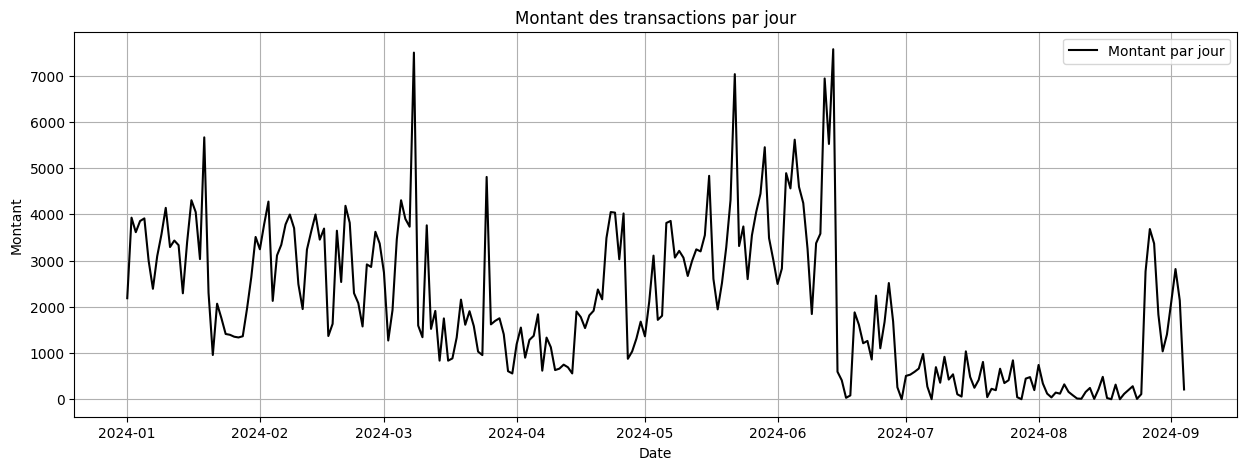

In [282]:
### Grouper les données par jour et tracer le montant total par jour

montant_per_day = data['Montant_Rgl'].resample('D').sum()

# Tracer le montant total par jour
plt.figure(figsize=(15, 5))
plt.plot(montant_per_day.index, montant_per_day, label='Montant par jour', color='black')
plt.title('Montant des transactions par jour')
plt.xlabel('Date')
plt.ylabel('Montant')
plt.legend()
plt.grid()
plt.show()

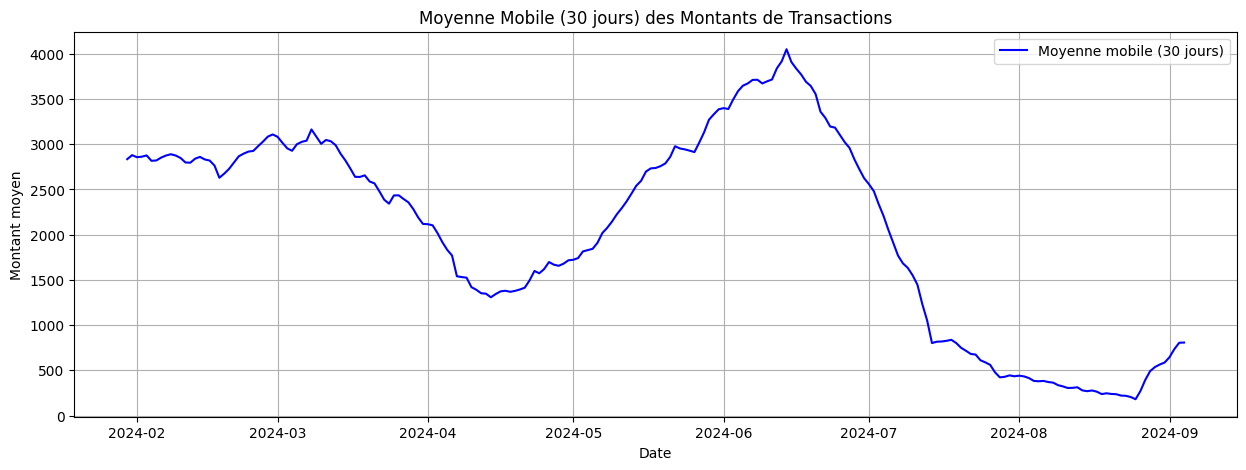

In [283]:
import matplotlib.pyplot as plt

# Calcul de la moyenne mobile du montant sur 30 jours
montant_per_day_rolling = montant_per_day.rolling(window=30).mean()

# Tracer la moyenne mobile
plt.figure(figsize=(15, 5))
plt.plot(montant_per_day_rolling.index, montant_per_day_rolling, label='Moyenne mobile (30 jours)', color='blue')
plt.title('Moyenne Mobile (30 jours) des Montants de Transactions')
plt.xlabel('Date') 
plt.ylabel('Montant moyen')  
plt.legend()
plt.grid()
plt.show()

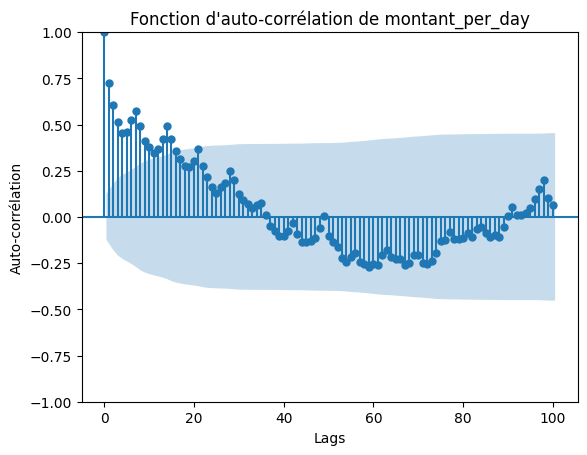

In [284]:
# Calculer et tracer l'auto-correlation
plot_acf(montant_per_day, lags=100)
plt.xlabel('Lags')
plt.ylabel('Auto-corrélation')
plt.title('Fonction d\'auto-corrélation de montant_per_day')
plt.show()

In [285]:
### appliquant le test de stationnarite Dickey-Fuller
test=adfuller(montant_per_day)
print('statistique de test est : ' , test[0])
print('P-value est : ' , test[1])
print('la valeur critique est : ' , test[4])

###verification de la stationnarite 
if test[1]<0.05:
        print('Rejet de l\'hypothèse nulle, la serie est stationnaire')
else :
    print('la serie est  non-stationnaire ')

statistique de test est :  -1.5836233401871216
P-value est :  0.49181462495336314
la valeur critique est :  {'1%': np.float64(-3.4586084859607156), '5%': np.float64(-2.873972159235721), '10%': np.float64(-2.57339565928848)}
la serie est  non-stationnaire 


### **Etude transaction pae semaine

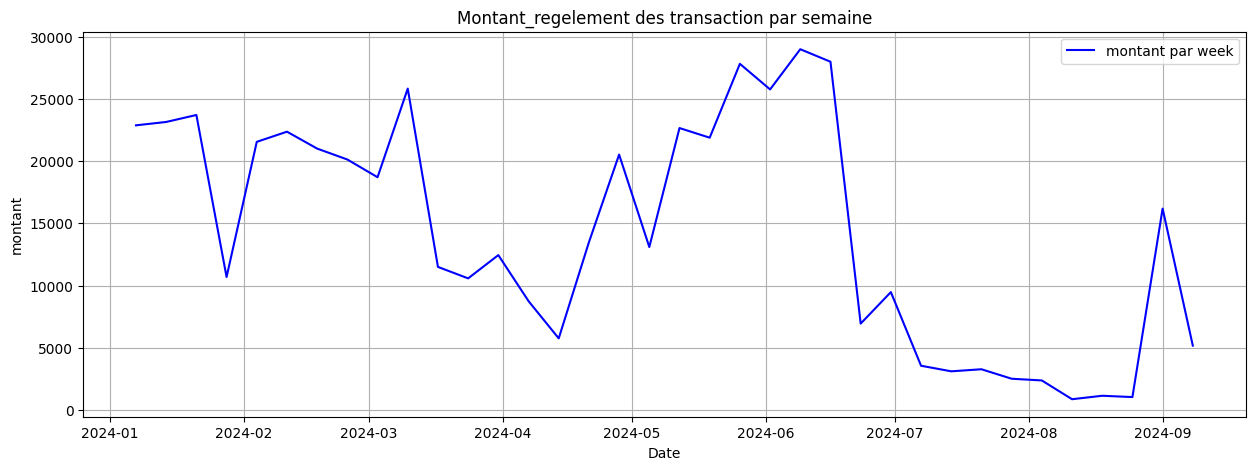

In [286]:
### gouper les données par semaine
montant_per_week=data['Montant_Rgl'].resample('W').sum()

plt.figure(figsize=(15,5))
plt.plot(montant_per_week.index , montant_per_week , label='montant par week' , color='blue')
plt.title('Montant_regelement des transaction par semaine')
plt.xlabel('Date')
plt.ylabel('montant')
plt.legend()
plt.grid()
plt.show()

<Figure size 1500x500 with 0 Axes>

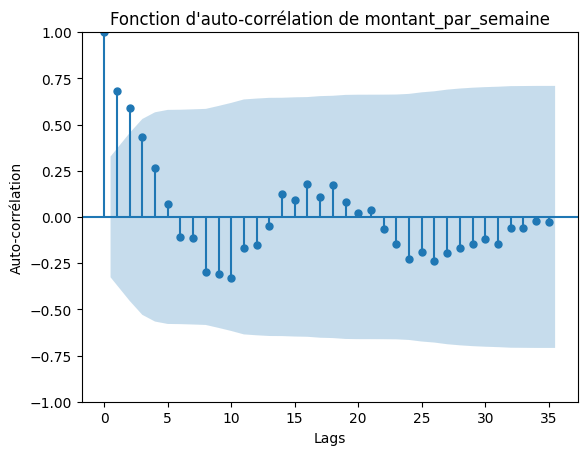

In [287]:
# Calculer et tracer l'auto-correlation
plt.figure(figsize=(15,5))
plot_acf(montant_per_week, lags=35)
plt.xlabel('Lags')
plt.ylabel('Auto-corrélation')
plt.title('Fonction d\'auto-corrélation de montant_par_semaine')
plt.show()

In [288]:
### appliquant le test de stationnarite Dickey-Fuller
test_W=adfuller(montant_per_week)
print('statistique de test est : ' , test_W[0])
print('P-value est : ' , test_W[1])
print('la valeur critique est : ' , test_W[4])

###verification de la stationnarite 
if test_W[1]<0.05:
        print('Rejet de l\'hypothèse nulle, la serie est stationnaire')
else :
    print('la serie est  non-stationnaire ')

statistique de test est :  0.3690461934145874
P-value est :  0.9802997376935598
la valeur critique est :  {'1%': np.float64(-3.7238633119999998), '5%': np.float64(-2.98648896), '10%': np.float64(-2.6328004)}
la serie est  non-stationnaire 


### **Etude de transaction par mois

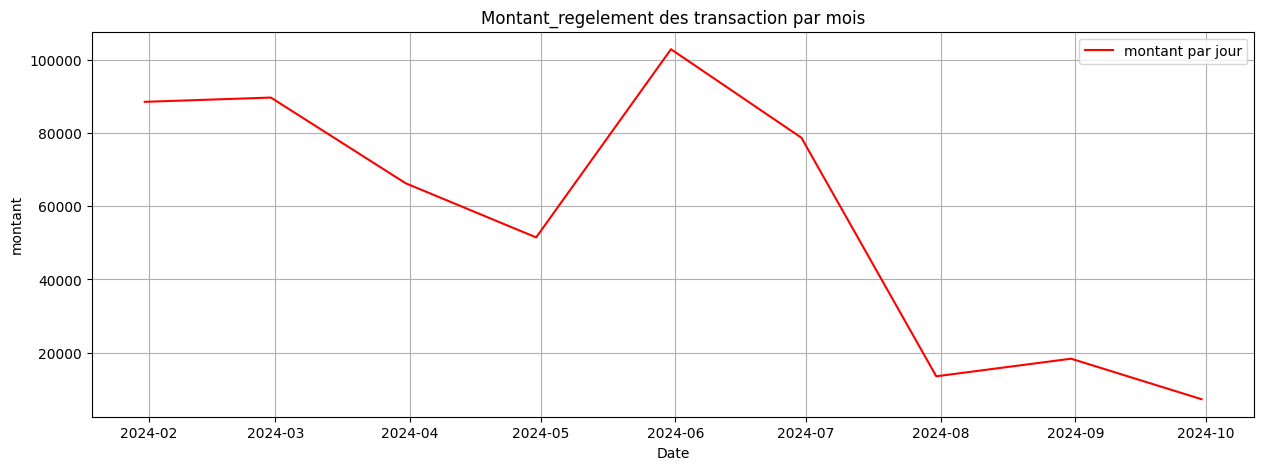

In [289]:
### gouper les données par mois
montant_per_month=data['Montant_Rgl'].resample('ME').sum()

plt.figure(figsize=(15,5))
plt.plot(montant_per_month.index , montant_per_month , label='montant par jour' , color='red')
plt.title('Montant_regelement des transaction par mois')
plt.xlabel('Date')
plt.ylabel('montant')
plt.legend()
plt.grid()
plt.show()

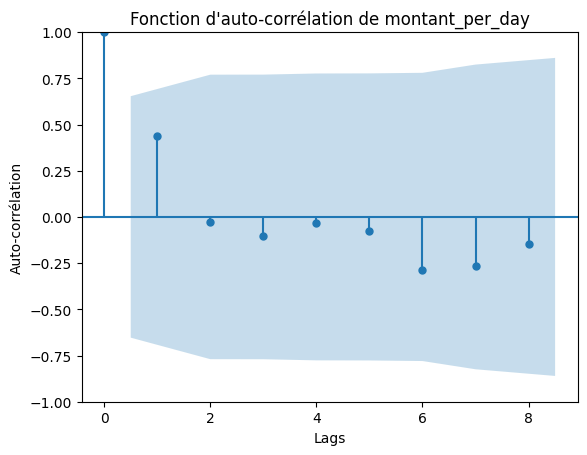

In [290]:
# Calculer et tracer l'auto-correlation
plot_acf(montant_per_month, lags=8)
plt.xlabel('Lags')
plt.ylabel('Auto-corrélation')
plt.title('Fonction d\'auto-corrélation de montant_per_day')
plt.show()

In [291]:
### appliquant le test de stationnarite Dickey-Fuller
test_ME=adfuller(montant_per_month)
print('statistique de test est : ' , test_ME[0])
print('P-value est : ' , test_ME[1])
print('la valeur critique est : ' , test_ME[4])

###verification de la stationnarite 
if test_W[1]<0.05:
        print('Rejet de l\'hypothèse nulle, la serie est stationnaire')
else :
    print('la serie est  non-stationnaire ')

statistique de test est :  1.1798649321631112
P-value est :  0.9958437734350417
la valeur critique est :  {'1%': np.float64(-5.354256481481482), '5%': np.float64(-3.6462381481481483), '10%': np.float64(-2.901197777777778)}
la serie est  non-stationnaire 


## Tache 3 : Analyse des tendances d'utilisation des cartes prépayées :

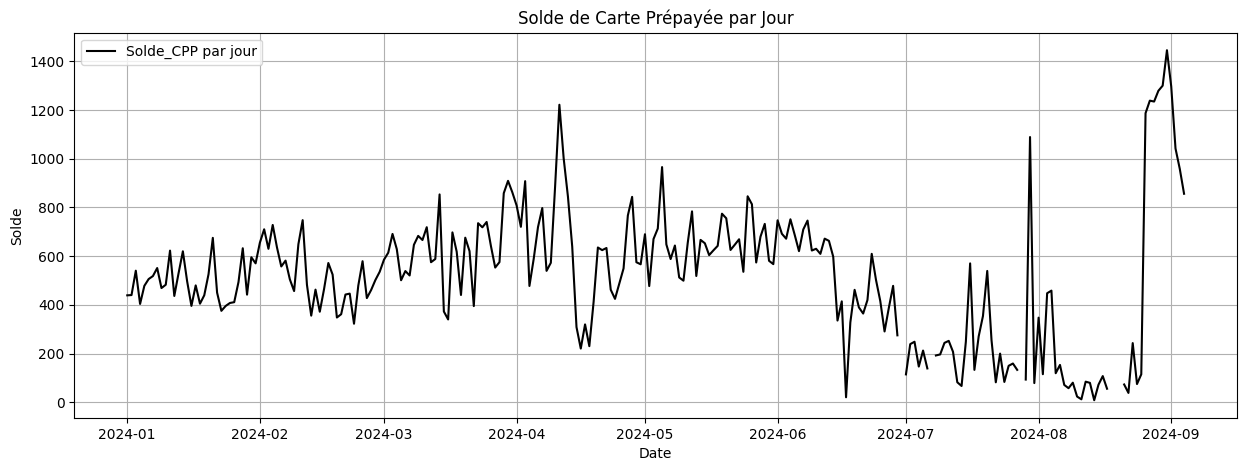

In [292]:
### Grouper les données de Solde_CPP par jour
solde_cpp_per_day = data['Solde_CPP'].resample('D').mean()

# Tracer le solde moyen par jour
plt.figure(figsize=(15, 5))
plt.plot(solde_cpp_per_day.index, solde_cpp_per_day, label='Solde_CPP par jour', color='black')
plt.title('Solde de Carte Prépayée par Jour')
plt.xlabel('Date')
plt.ylabel('Solde')
plt.legend()
plt.grid()
plt.show()

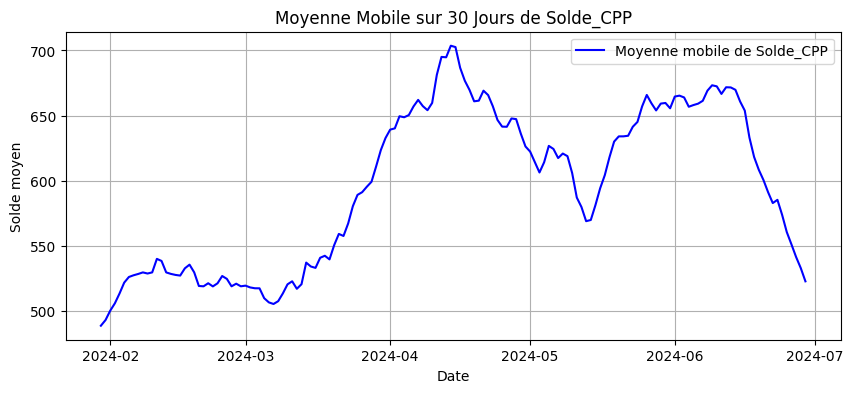

In [293]:
### Calculer la moyenne mobile sur 30 jours pour Solde_CPP
solde_per_day_rolling = solde_cpp_per_day.rolling(window=30).mean()

# Tracer la moyenne mobile de Solde_CPP
plt.figure(figsize=(10, 4))
plt.plot(solde_per_day_rolling.index, solde_per_day_rolling, label='Moyenne mobile de Solde_CPP', color='blue')
plt.title('Moyenne Mobile sur 30 Jours de Solde_CPP')
plt.xlabel('Date')  
plt.ylabel('Solde moyen')
plt.legend()
plt.grid()
plt.show()

## Tache 4 : Analyse du comportement des clients :

In [294]:
# Vérification de l'unicité des noms de clients
resultat = data.groupby('Bénéficiaire_CPP')['ID_CartePP'].nunique().reset_index()

# Étape 2 : Filtrer les résultats pour garder les noms avec plusieurs ID_CartePP
noms_avec_plusieurs_ids = resultat[resultat['ID_CartePP'] > 1]

# Afficher les résultats
noms_avec_plusieurs_ids.describe()

,ID_CartePP
count,100.000000
mean,2.270000
std,0.600589
min,2.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,6.000000


### **Etude du total 

In [295]:
# Étape 1 : Grouper les données par 'ID_CartePP' et sommer les montants réglés
depense_per_client = data.groupby('ID_CartePP')['Montant_Rgl'].sum().reset_index()

# Étape 2 : Joindre avec le DataFrame original pour obtenir le nom du bénéficiaire
depense_per_client = depense_per_client.merge(data[['ID_CartePP', 'Bénéficiaire_CPP']], on='ID_CartePP', how='left')

# Étape 3 : Renommer les colonnes pour plus de clarté
depense_per_client.columns = ['ID_CartePP', 'Total Dépense', 'Client']

# Étape 4 : Supprimer les doublons si nécessaire pour garder un seul enregistrement par carte
depense_per_client = depense_per_client.drop_duplicates(subset=['ID_CartePP'])

# Étape 5 : Trier les clients par total des dépenses de manière décroissante
depense_per_client = depense_per_client.sort_values(by='Total Dépense', ascending=False)

depense_per_client=depense_per_client[['Client', 'ID_CartePP', 'Total Dépense']]
# Afficher le DataFrame résultant

depense_per_client

,Client,ID_CartePP,Total Dépense
15177,RIFAI,CND_UA00032621/2023,14203.572536
4451,CHAGH,2759346313129471,12165.500000
2252,BOUICHENADE,1425863115513158,11338.000000
10955,DOUDOUH,6632395296331911,9659.000000
1467,MINTOAMA,1271645626186163,9067.000000
...,...,...,...
11789,BOUZIDI,9159723385146314,2.000000
11316,BENRBIEA,7173439323935434,2.000000
11601,EL ANSARI,8696718292873527,2.000000
11314,MAHDA,7152171799833236,2.000000


In [296]:
### Obtenir les 10 principaux dépensiers

# Sélectionner les 10 premiers clients en fonction du total des dépenses
top_depensiers = depense_per_client.head(10)
top_depensiers

,Client,ID_CartePP,Total Dépense
15177,RIFAI,CND_UA00032621/2023,14203.572536
4451,CHAGH,2759346313129471,12165.500000
2252,BOUICHENADE,1425863115513158,11338.000000
10955,DOUDOUH,6632395296331911,9659.000000
1467,MINTOAMA,1271645626186163,9067.000000
3880,SELMANI,2426337888522318,8676.500000
8949,EL MOUNTADAR,4484248832286969,8539.500000
3610,BASSALH,2298119326996171,8255.000000
919,SEGBEDJI Yao,1258585224496584,7860.000000
9868,EN-NAHAS El,5676118786483647,7707.000000


In [297]:
### Calculer le solde mensuel pour les 10 principaux clients

# Extraire les noms des 10 principaux clients
top_clients = top_depensiers['Client'].values

# Filtrer les transactions des clients principaux
top_transaction_client = data[data['Bénéficiaire_CPP'].isin(top_clients)]

# Grouper les données par mois et client, puis sommer les soldes
solde_per_month = top_transaction_client.groupby([pd.Grouper(freq='ME'), 'Bénéficiaire_CPP'])['Solde_CPP'].sum().reset_index()

solde_per_month

,Date_heure_Règlement,Bénéficiaire_CPP,Solde_CPP
0,2024-01-31,BASSALH,33763.50
1,2024-01-31,BOUICHENADE,35621.00
2,2024-01-31,CHAGH,44882.50
3,2024-01-31,DOUDOUH,39677.50
4,2024-01-31,EL MOUNTADAR,18024.50
...,...,...,...
66,2024-07-31,SELMANI,2620.25
67,2024-08-31,DOUDOUH,27729.10
68,2024-08-31,SELMANI,20399.50
69,2024-09-30,DOUDOUH,8718.80


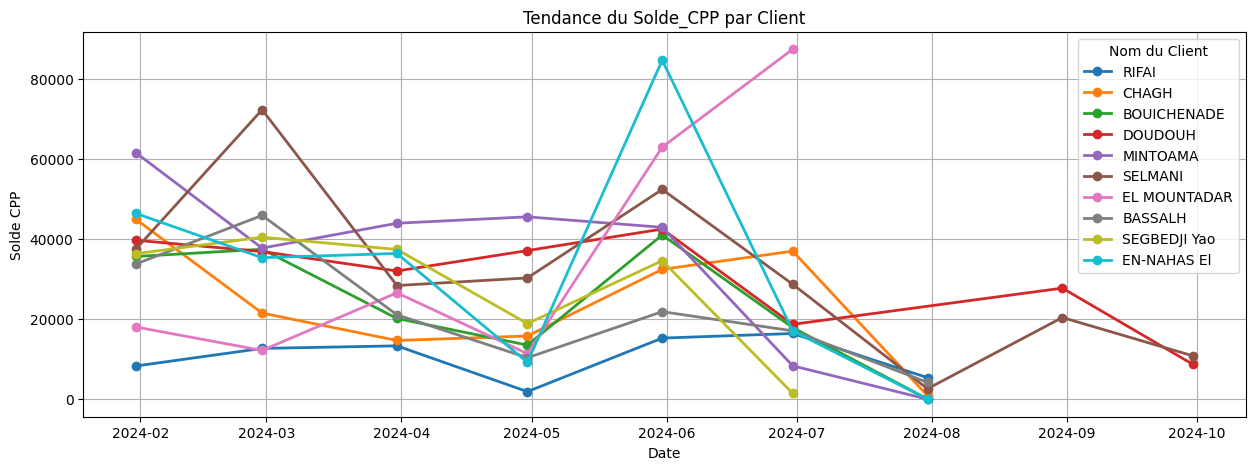

In [298]:
### Tracer la tendance du Solde_CPP par client
plt.figure(figsize=(15, 5))

# Boucler à travers chaque client dans les clients principaux
for CL in top_clients:
    # Filtrer les données pour le client actuel
    client_data = solde_per_month[solde_per_month['Bénéficiaire_CPP'] == CL]

    # Tracer les soldes pour le client actuel
    plt.plot(client_data['Date_heure_Règlement'], client_data['Solde_CPP'],
             label=CL, linewidth=2, marker='o', markersize=6)

plt.title('Tendance du Solde_CPP par Client')
plt.xlabel('Date')
plt.ylabel('Solde CPP')
plt.legend(title='Nom du Client', bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

In [299]:
# Appliquer le test de stationnarité Dickey-Fuller pour chaque client

# Boucler à travers chaque client dans les clients principaux
for CL in top_clients:
    # Filtrer les données pour le client actuel
    client_data = solde_per_month[solde_per_month['Bénéficiaire_CPP'] == CL]
    
    ### Appliquer le test de stationnarité Dickey-Fuller
    print(CL) 
    print('-------------------------------')
    test = adfuller(client_data['Solde_CPP'])
    
    # Afficher les résultats du test
    print('Statistique de test est :', test[0])  # Statistique de test
    print('P-value est :', test[1])              # Valeur p
    print('Valeur critique est :', test[4])      # Valeurs critiques pour la stationnarité
    
    ### Vérification de la stationnarité
    if test[1] < 0.05:
        print('Rejet de l\'hypothèse nulle, la série est stationnaire')
    else:
        print('La série est non-stationnaire')
    
    print('--------------------------------')


RIFAI
-------------------------------
Statistique de test est : -4.065854636707315
P-value est : 0.0011023391631355668
Valeur critique est : {'1%': np.float64(-6.045114), '5%': np.float64(-3.9292800000000003), '10%': np.float64(-2.98681)}
Rejet de l'hypothèse nulle, la série est stationnaire
--------------------------------
CHAGH
-------------------------------
Statistique de test est : -2.323225056182204
P-value est : 0.16458679353614358
Valeur critique est : {'1%': np.float64(-6.045114), '5%': np.float64(-3.9292800000000003), '10%': np.float64(-2.98681)}
La série est non-stationnaire
--------------------------------
BOUICHENADE
-------------------------------
Statistique de test est : -2.273080491125246
P-value est : 0.18079706531327072
Valeur critique est : {'1%': np.float64(-6.045114), '5%': np.float64(-3.9292800000000003), '10%': np.float64(-2.98681)}
La série est non-stationnaire
--------------------------------
DOUDOUH
-------------------------------
Statistique de test est : 0.

In [300]:
# Appliquer le test de Mann-Kendall pour chaque client
'''
# Le test de Mann-Kendall est utilisé pour détecter des tendances dans des séries temporelles, 
en vérifiant si les valeurs augmentent ou diminuent de manière significative au fil du temps.
'''
# Boucler à travers chaque client dans les clients principaux
for CL in top_clients:
    # Filtrer les données pour le client actuel
    client_data = solde_per_month[solde_per_month['Bénéficiaire_CPP'] == CL]
    
    # Appliquer le test de Mann-Kendall
    result = mk.original_test(client_data['Solde_CPP'])
    
    # Afficher les résultats
    print('Pour :', CL)  
    print(result)        
    print('***************************************' + '\n')


Pour : RIFAI
Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.5480055723613093), z=np.float64(0.6007514091861106), Tau=np.float64(0.23809523809523808), s=np.float64(5.0), var_s=44.333333333333336, slope=np.float64(929.1650000000004), intercept=np.float64(9904.855))
***************************************

Pour : CHAGH
Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.5480055723613093), z=np.float64(-0.6007514091861106), Tau=np.float64(-0.23809523809523808), s=np.float64(-5.0), var_s=44.333333333333336, slope=np.float64(-3118.625), intercept=np.float64(30856.875))
***************************************

Pour : BOUICHENADE
Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.22955621387891956), z=np.float64(-1.2015028183722212), Tau=np.float64(-0.42857142857142855), s=np.float64(-9.0), var_s=44.333333333333336, slope=np.float64(-5022.625), intercept=np.float64(35224.175))
***************************************

Pour : DOUDOUH
Mann_Kendall_Test(tr

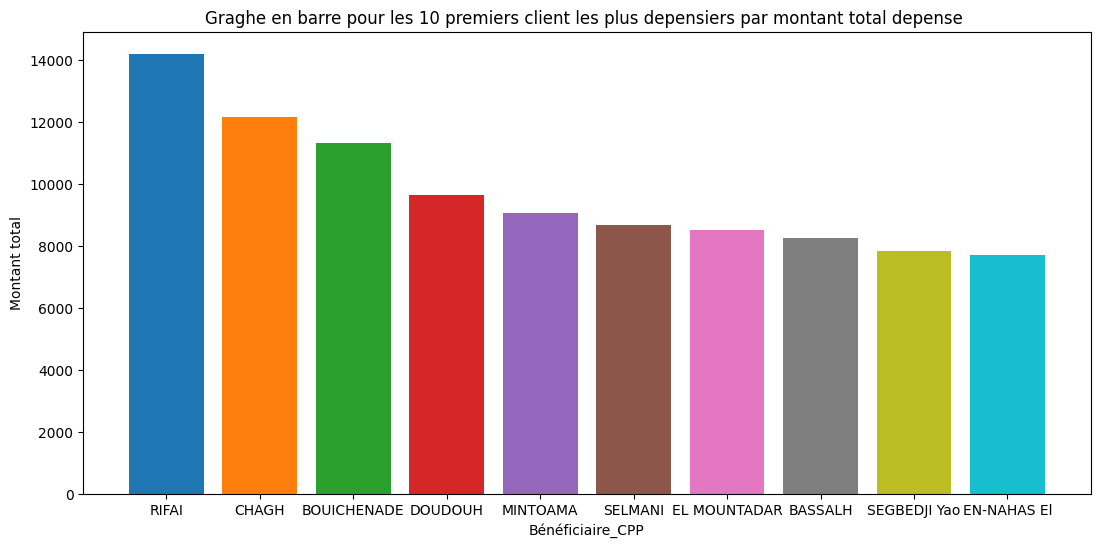

In [301]:
#### Graghe en barre pour les 10 premiers client les plus depensiers par montant total depense 
colors = plt.colormaps['tab10'](np.linspace(0, 1, len(top_depensiers)))

plt.figure(figsize=(13,6))
plt.bar(top_depensiers['Client'] , top_depensiers['Total Dépense']  , color=colors)
plt.title('Graghe en barre pour les 10 premiers client les plus depensiers par montant total depense ')
plt.xlabel('Bénéficiaire_CPP')
plt.ylabel('Montant total')
plt.show()

### **Etude de la moyenne

In [302]:
# Étape 1 : Grouper les données par 'ID_CartePP' et sommer les montants réglés
mean_depense_per_client = data.groupby('ID_CartePP')['Montant_Rgl'].mean().reset_index()

# Étape 2 : Joindre avec le DataFrame original pour obtenir le nom du bénéficiaire
mean_depense_per_client = mean_depense_per_client.merge(data[['ID_CartePP', 'Bénéficiaire_CPP']], on='ID_CartePP', how='left')

# Étape 3 : Renommer les colonnes pour plus de clarté
mean_depense_per_client.columns = ['ID_CartePP', 'Mean Depense', 'Client']

# Étape 4 : Supprimer les doublons si nécessaire pour garder un seul enregistrement par carte
mean_depense_per_client = mean_depense_per_client.drop_duplicates(subset=['ID_CartePP'])

# Étape 5 : Trier les clients par total des dépenses de manière décroissante
mean_depense_per_client = mean_depense_per_client.sort_values(by='Mean Depense', ascending=False)

# Afficher le DataFrame résultant
mean_depense_per_client[['Client', 'ID_CartePP', 'Mean Depense']]

,Client,ID_CartePP,Mean Depense
15177,RIFAI,CND_UA00032621/2023,1014.540895
15134,ASSELLALOU MOHAMED,CND_UA00029327/2022,576.000000
15136,EL YAAGOUBI,CND_UA00030018/2022,476.725783
15207,REGRAGUI,CND_UA00032699/2023,457.918074
15148,SELMANI,CND_UA00031517/2023,364.339395
...,...,...,...
11789,BOUZIDI,9159723385146314,2.000000
11914,BOUAJAJA,9224683397564235,2.000000
11269,ELAYATI,6823678547655982,2.000000
10567,HARIS,6392234362574426,2.000000


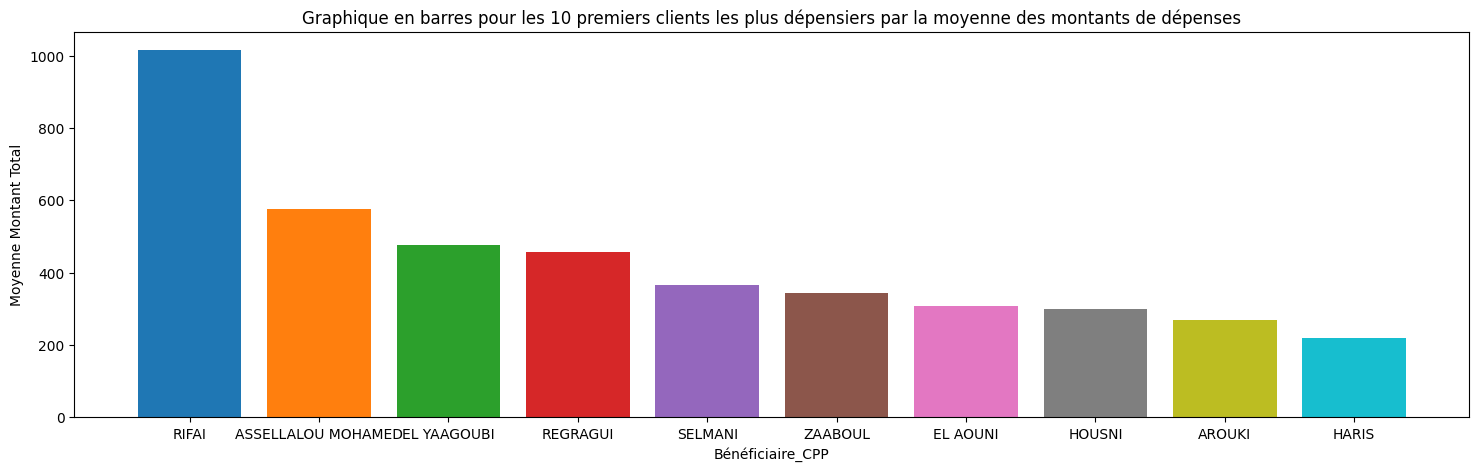

In [303]:
# Sélectionner les 10 clients les plus dépensiers selon la moyenne des dépenses
top_mean_depense_per_client = mean_depense_per_client.head(10)

# Tracer le graphique en barres pour les 10 premiers clients
plt.figure(figsize=(18, 5))
plt.bar(top_mean_depense_per_client['Client'], 
        top_mean_depense_per_client['Mean Depense'], 
        color=colors)  

plt.title('Graphique en barres pour les 10 premiers clients les plus dépensiers par la moyenne des montants de dépenses')
plt.xlabel('Bénéficiaire_CPP')  
plt.ylabel('Moyenne Montant Total')  
plt.show()

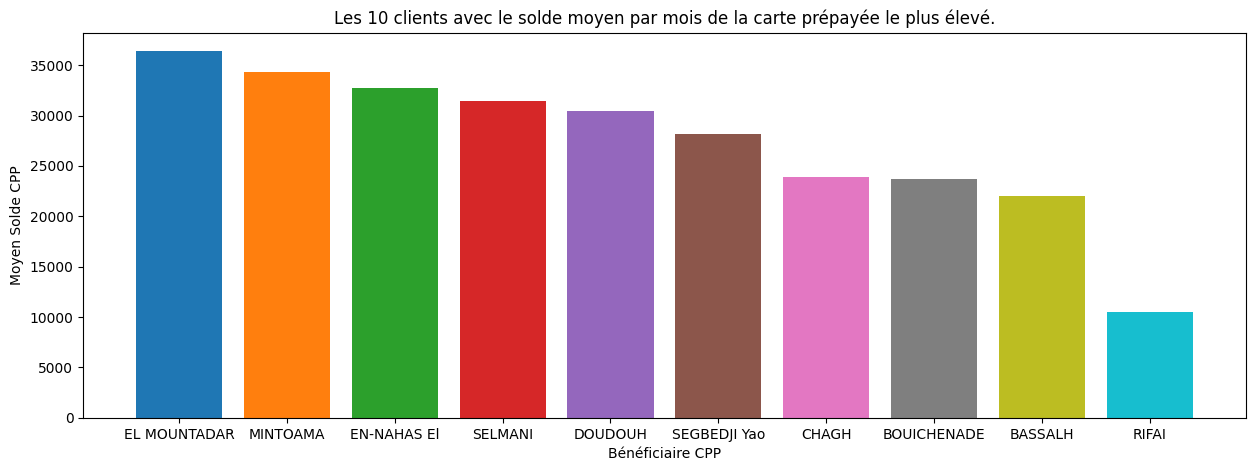

In [304]:
# Grouper les données par client et calculer le solde moyenne par mois
group_solde_per_month_client = solde_per_month.groupby('Bénéficiaire_CPP')['Solde_CPP'].mean().reset_index()

# Trier les clients par solde moyen en ordre décroissant
group_solde_per_month_client = group_solde_per_month_client.sort_values(by='Solde_CPP', ascending=False)

# Tracer le graphique en barres pour les clients avec le solde moyen le plus élevé
plt.figure(figsize=(15, 5))
plt.bar(group_solde_per_month_client['Bénéficiaire_CPP'], 
        group_solde_per_month_client['Solde_CPP'], 
        color=colors)  

plt.title('Les 10 clients avec le solde moyen par mois de la carte prépayée le plus élevé.')
plt.xlabel('Bénéficiaire CPP')  
plt.ylabel('Moyen Solde CPP')  
plt.show()


##   Tache 5 :  Analyse des montants restants et des soldes à zéro :

In [305]:
data_montant_impaye = data[data['Montant_Rst'] > 0]

# Étape 1 : Grouper les données par 'ID_CartePP' et sommer les montants réglés
montant_impaye = data_montant_impaye.groupby('ID_CartePP')['Montant_Rst'].sum().reset_index()

# Étape 2 : Joindre avec le DataFrame original pour obtenir le nom du bénéficiaire
montant_impaye = montant_impaye.merge(data_montant_impaye[['ID_CartePP', 'Bénéficiaire_CPP']], on='ID_CartePP', how='left')

# Étape 3 : Renommer les colonnes pour plus de clarté
montant_impaye.columns = ['ID_CartePP', 'Total_montant_Rst', 'Client']

# Étape 4 : Supprimer les doublons si nécessaire pour garder un seul enregistrement par carte
montant_impaye = montant_impaye.drop_duplicates(subset=['ID_CartePP'])

# Étape 5 : Trier les clients par total des dépenses de manière décroissante
montant_impaye = montant_impaye.sort_values(by='Total_montant_Rst', ascending=False)
montant_impaye = montant_impaye.dropna(subset=['Client'])

# Afficher le DataFrame résultant
montant_impaye[['Client', 'ID_CartePP', 'Total_montant_Rst']].head(10)

,Client,ID_CartePP,Total_montant_Rst
33,RIFAI,CND_UA00032621/2023,7.629394e-05
21,SELMANI,CND_UA00031517/2023,4.386902e-05
43,REGRAGUI,CND_UA00032699/2023,2.288818e-05
16,HOUSNI,9653163512989898,2.145767e-06
37,SEGBEDJI Yao,CND_UA00032630/2023,1.907349e-06
20,EL YAAGOUBI,CND_UA00030018/2022,1.907349e-06
28,CHAGH,CND_UA00032579/2023,1.907349e-06
14,DOUDOUH,9632819172214156,1.907349e-06
7,KADIRI Lalla,3515945654632134,9.536743e-07
11,AMEZIANE,9234857668936733,9.536743e-07


In [306]:
montant_impaye.describe()

,Total_montant_Rst
count,3.200000e+01
mean,4.902482e-06
std,1.557798e-05
min,2.664535e-14
25%,4.884981e-14
50%,3.641532e-13
75%,1.192093e-06
max,7.629394e-05


In [307]:
# Filtrer les données où le solde_CPP est égal à 0
solde_CPP_null = data[data['Solde_CPP'] == 0.0]

print(solde_CPP_null)

# Vérifier si aucune entrée n'existe
if solde_CPP_null.empty:
    print("Il n'existe aucun solde_CPP égal à 0.")
else:
    print(f"Il y a {len(solde_CPP_null)} entrées avec solde_CPP égal à 0.")


Empty DataFrame
Columns: [Montant_Rgl, Montant_Versé, Montant_Rst, ID_Client, Client, ID_CartePP, Bénéficiaire_CPP, Solde_CPP, ID_Restaurant, Restaurant, ID_User, Prenom User]
Index: []
Il n'existe aucun solde_CPP égal à 0.


In [308]:
montant_impaye

,ID_CartePP,Total_montant_Rst,Client
33,CND_UA00032621/2023,7.629394e-05,RIFAI
21,CND_UA00031517/2023,4.386902e-05,SELMANI
43,CND_UA00032699/2023,2.288818e-05,REGRAGUI
16,9653163512989898,2.145767e-06,HOUSNI
37,CND_UA00032630/2023,1.907349e-06,SEGBEDJI Yao
20,CND_UA00030018/2022,1.907349e-06,EL YAAGOUBI
28,CND_UA00032579/2023,1.907349e-06,CHAGH
14,9632819172214156,1.907349e-06,DOUDOUH
7,3515945654632134,9.536743e-07,KADIRI Lalla
11,9234857668936733,9.536743e-07,AMEZIANE


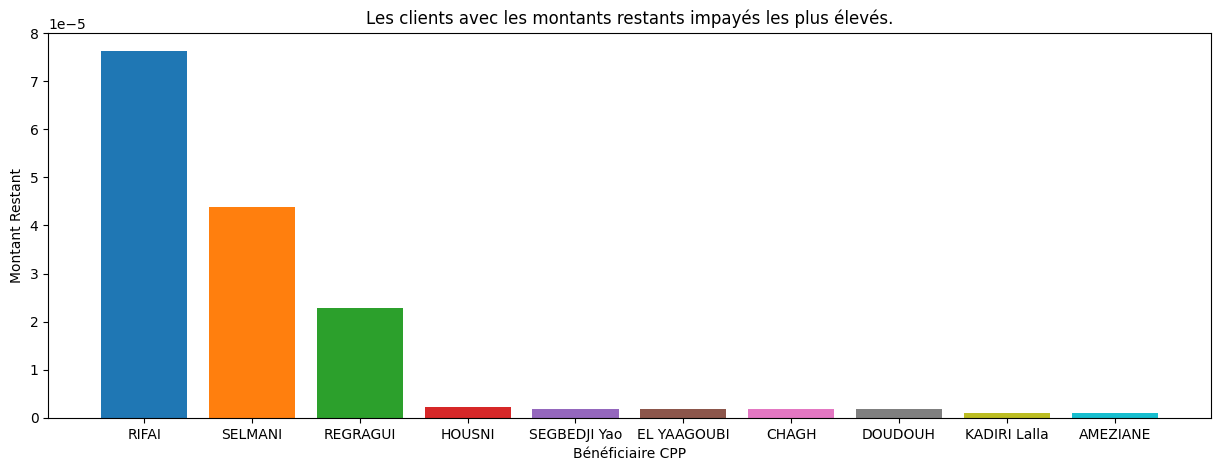

In [309]:
# Obtenir les 10 premiers clients avec les montants restants impayés les plus élevés
montant_res = montant_impaye.head(10)

# Tracer un graphique à barres des montants restants impayés par client
plt.figure(figsize=(15, 5))
plt.bar(montant_res['Client'], montant_res['Total_montant_Rst'], color=colors)
plt.title('Les clients avec les montants restants impayés les plus élevés.')
plt.xlabel('Bénéficiaire CPP')
plt.ylabel('Montant Restant')
plt.show()

## Tache 6 : Analyse des heures de pointe et des lieux les plus performants :

### **Analyse de restaurnt par montant reglement

In [310]:
# Grouper les transactions par restaurant et calculer le montant total des règlements
place_performance = data.groupby(['ID_Restaurant', 'Restaurant'])['Montant_Rgl'].sum().reset_index()

# Trier les résultats par le montant des règlements, en ordre décroissant
place_performance = place_performance.sort_values(by='Montant_Rgl', ascending=False)

place_performance

,ID_Restaurant,Restaurant,Montant_Rgl
0,RST10003,Snack Pizzeria - Rabat,207864.000000
2,RST10005,Café - Boulangerie - Pâtisserie - Rabat,183514.500000
4,RST10010,Lavomatic - Rabat,46274.139999
3,RST10006,Pharmacie & Parapharmacie - Rabat,33323.810572
5,RST10012,L'Casis Cafétéria HCZ,21571.500000
1,RST10004,Restaurant Gastronomique - Rabat,16405.000000
6,RST10014,Epicerie - Rabat,7903.250010


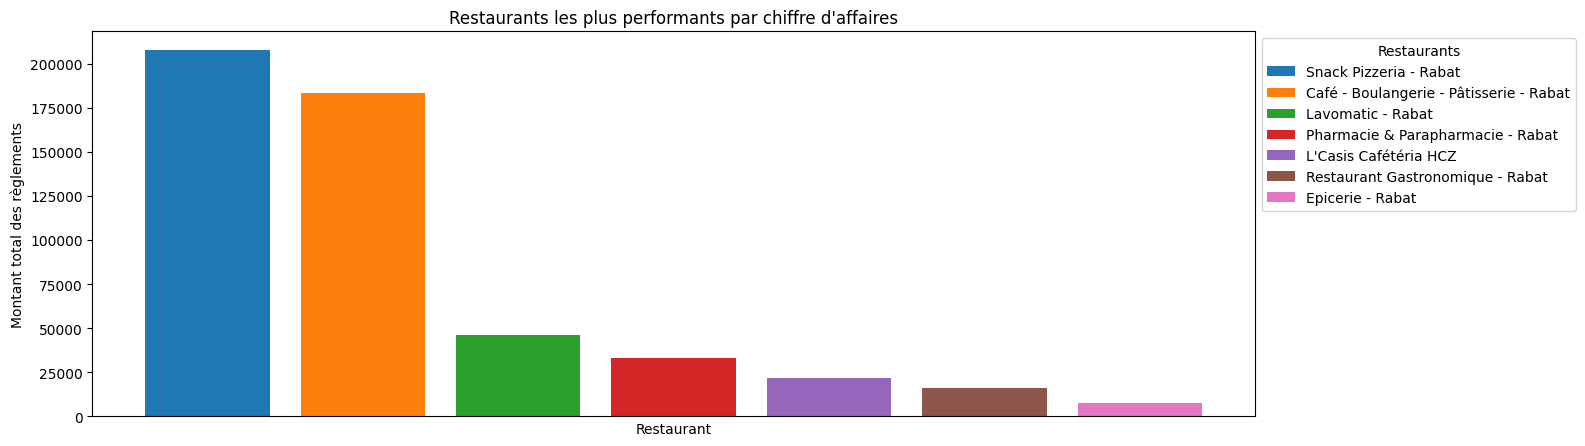

In [311]:
plt.figure(figsize=(15, 5))

# Création du graphique à barres de restaurant en fonction de Montant_Rgl
bars = plt.bar(place_performance['Restaurant'], place_performance['Montant_Rgl'], color=colors)

plt.title('Restaurants les plus performants par chiffre d\'affaires')
plt.xlabel('Restaurant')
plt.ylabel('Montant total des règlements')
plt.xticks([])
plt.legend(bars, place_performance['Restaurant'], title='Restaurants', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

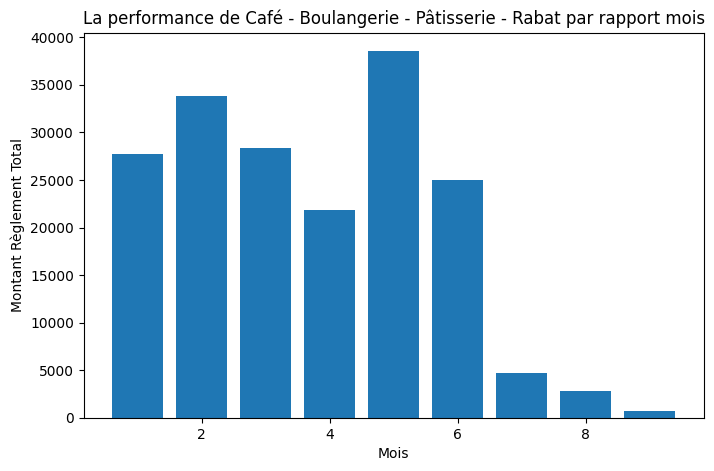

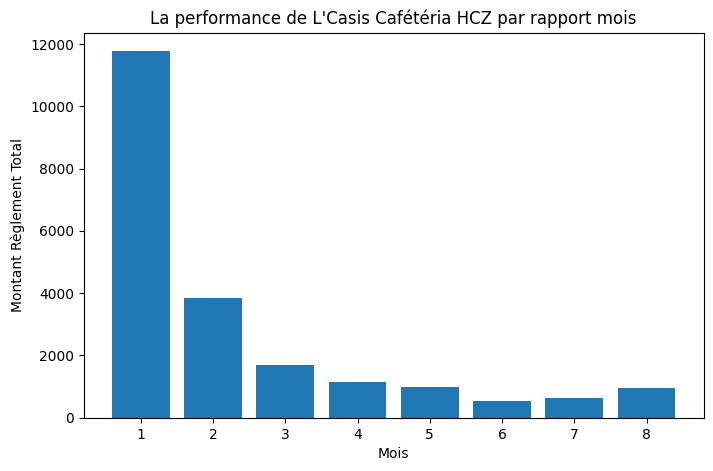

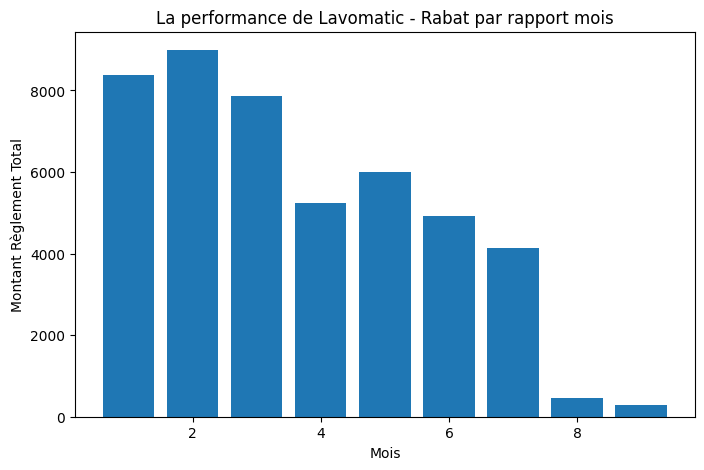

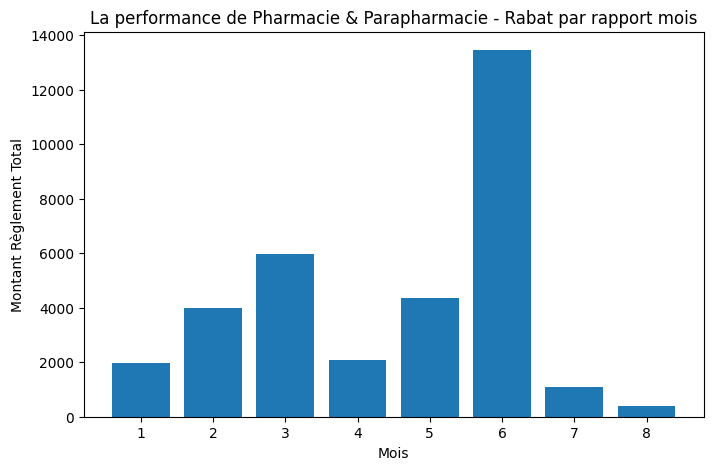

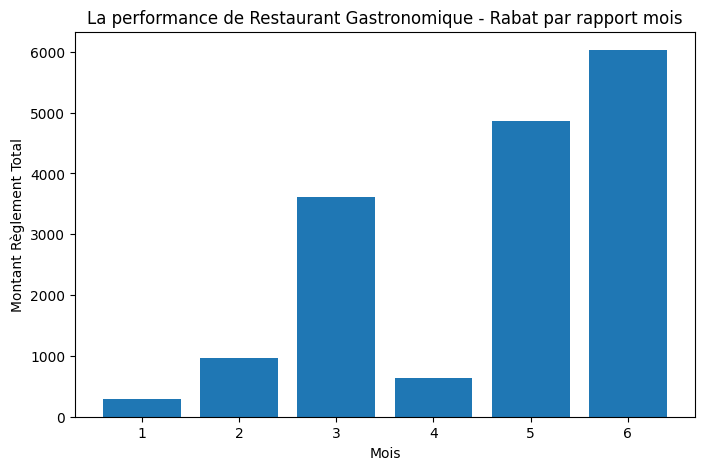

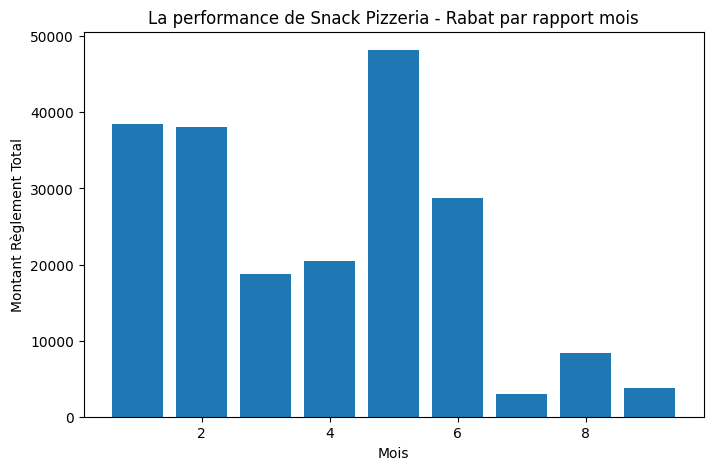

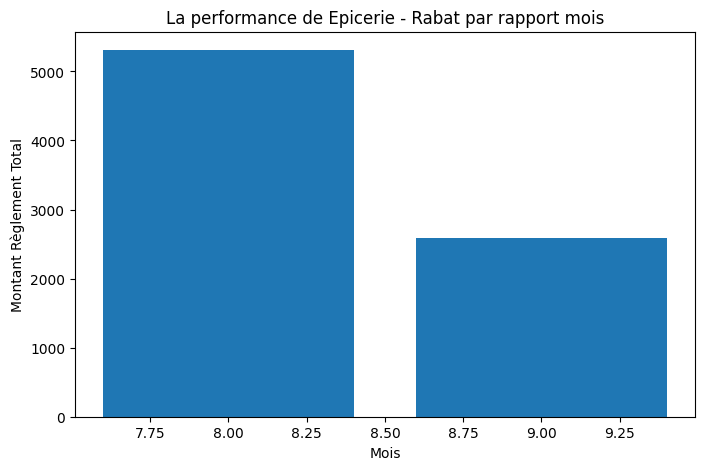

In [312]:
# Initialisation d'un dictionnaire pour stocker les données par restaurant
data_place_global = {}

# Groupement des données par mois et par restaurant, puis calcul du montant total réglé
place_and_heure = data.groupby([data.index.month, 'Restaurant'])['Montant_Rgl'].sum().reset_index()

# Pour chaque restaurant unique, extraire les données correspondantes
for place in place_and_heure['Restaurant'].unique():
    data_places = place_and_heure[place_and_heure['Restaurant'] == place]
    data_places = data_places.sort_values(by='Montant_Rgl', ascending=False)
    data_places = data_places.drop(['Restaurant'], axis=1)
    data_place_global[place] = data_places

# Pour chaque restaurant et son DataFrame associé, tracer les données
for name, df in data_place_global.items():
    plt.figure(figsize=(8, 5))  
    bars = plt.bar(df['Date_heure_Règlement'], df['Montant_Rgl'])
    plt.title(f'La performance de {name} par rapport mois')
    plt.xlabel('Mois')
    plt.ylabel('Montant Règlement Total')

# Afficher tous les graphiques
plt.show()


<Figure size 1500x800 with 0 Axes>

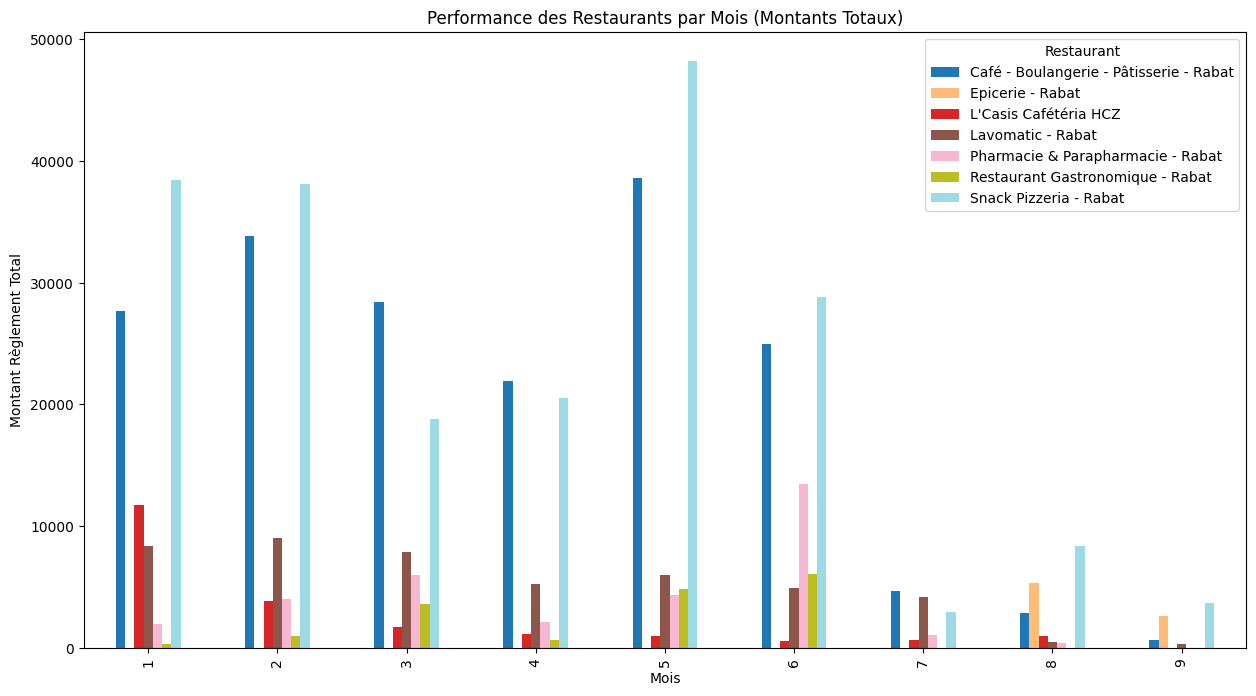

In [313]:
#Comparaison entre les montant reglement du restaurant par mois 
# Grouper les données par mois et restaurant, et calculer la somme des montants
total_per_month = data.groupby([data.index.month, 'Restaurant'])['Montant_Rgl'].sum().reset_index()

# Pivotement du DataFrame pour obtenir les heures comme index et les restaurants comme colonnes
pivot_table = total_per_month.pivot(index='Date_heure_Règlement', columns='Restaurant', values='Montant_Rgl').fillna(0)

# Créer un graphique à barres empilées pour les montants par heure
plt.figure(figsize=(15, 8))
pivot_table.plot(kind='bar', figsize=(15, 8), cmap='tab20')  # Utiliser une palette de couleurs
plt.title('Performance des Restaurants par Mois (Montants Totaux)')
plt.xlabel('Mois')
plt.ylabel('Montant Règlement Total')
plt.show()

### **Etude de restaurant par rapport l'heure : 

In [314]:
# Grouper les données par heure et calculer le montant total des règlements pour chaque heure
heure_point = data.groupby(data.index.hour)['Montant_Rgl'].sum().reset_index()

# Trier les résultats par montant des règlements, en ordre décroissant
heure_point = heure_point.sort_values(by='Montant_Rgl', ascending=False)

heure_point = heure_point.head(20)

heure_point

,Date_heure_Règlement,Montant_Rgl
8,12,73608.183151
15,19,44813.100002
13,17,42160.741028
9,13,41926.619995
12,16,38596.500497
11,15,35243.344219
6,10,33411.790001
10,14,32142.452999
7,11,31374.288481
14,18,29733.783813


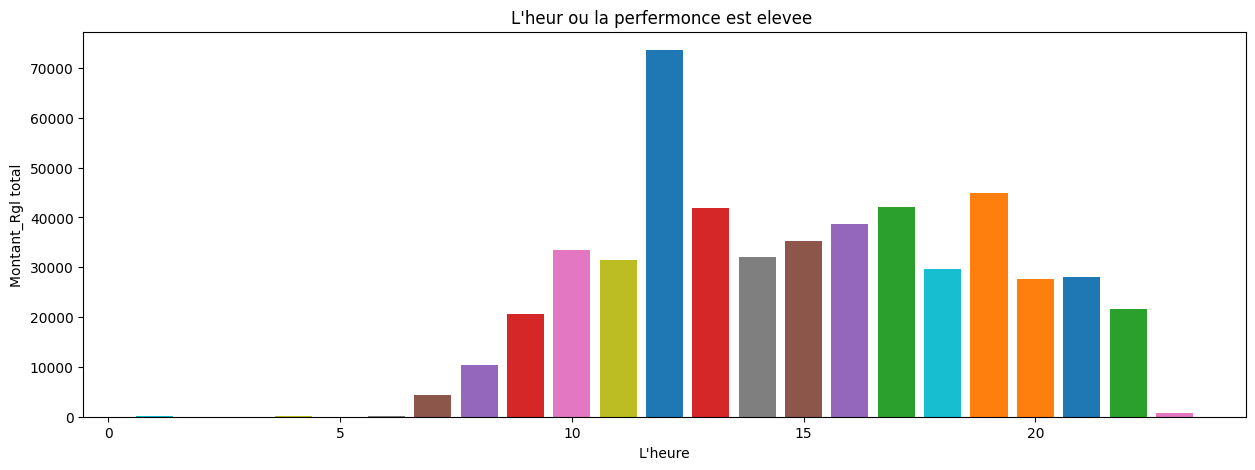

In [315]:
# Graphiques en barres pour visualiser les restaurants les plus performants par heures.

plt.figure(figsize=(15, 5))
bars = plt.bar(heure_point['Date_heure_Règlement'], heure_point['Montant_Rgl'], color=colors)
plt.title('L\'heur ou la perfermonce est elevee ')
plt.xlabel('L\'heure')
plt.ylabel('Montant_Rgl total')
plt.show()

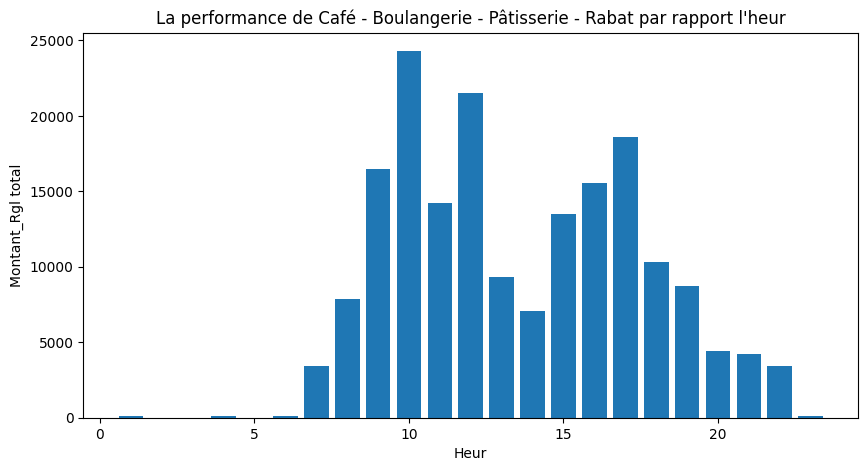

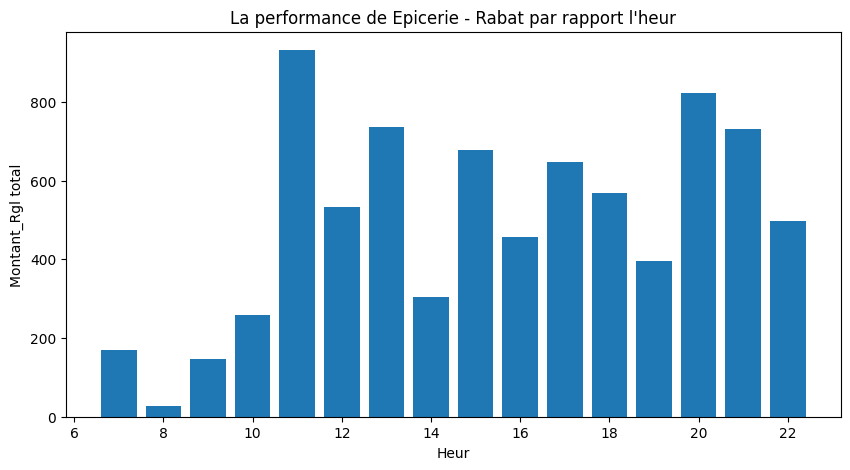

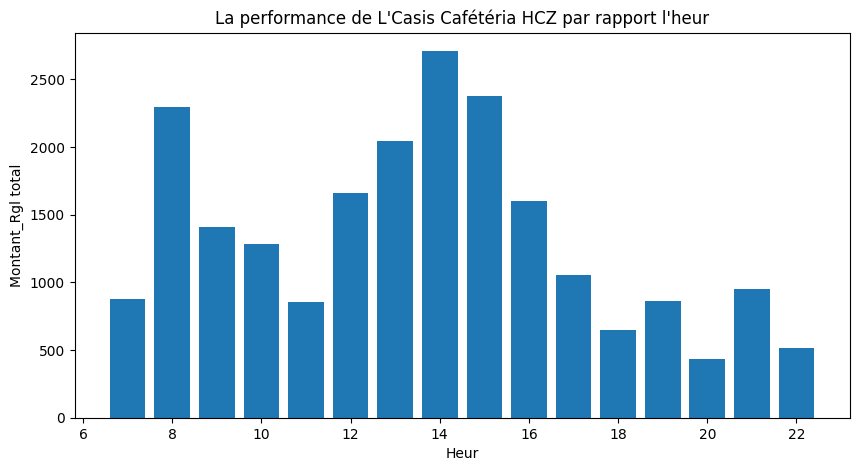

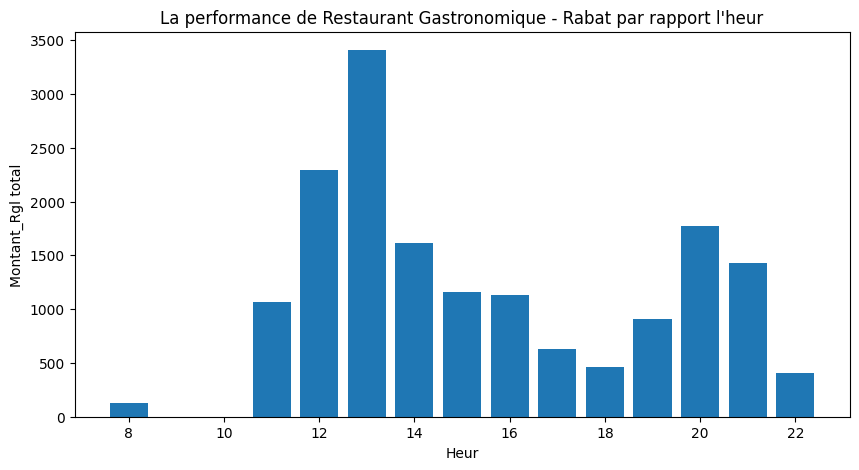

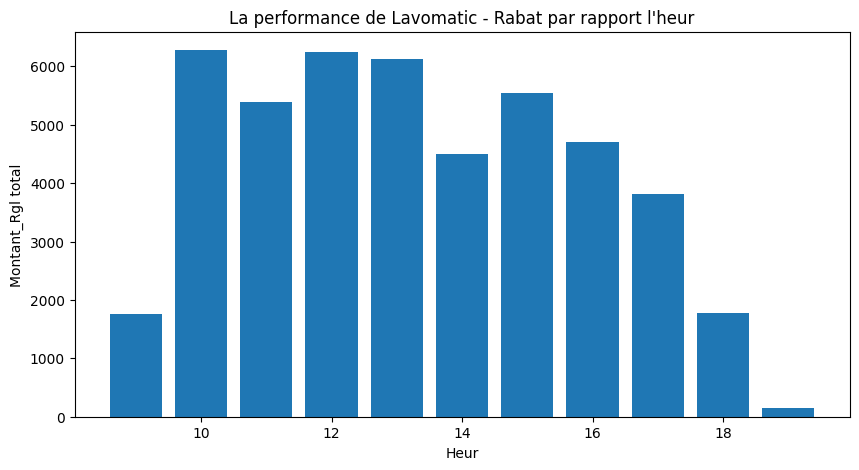

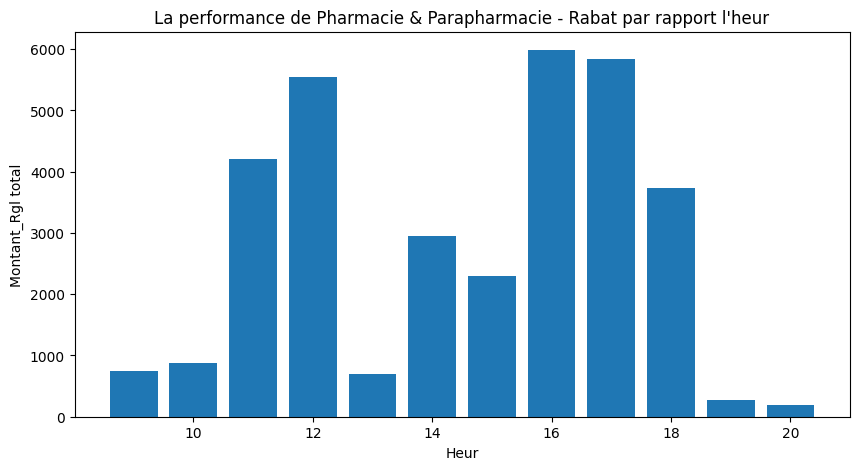

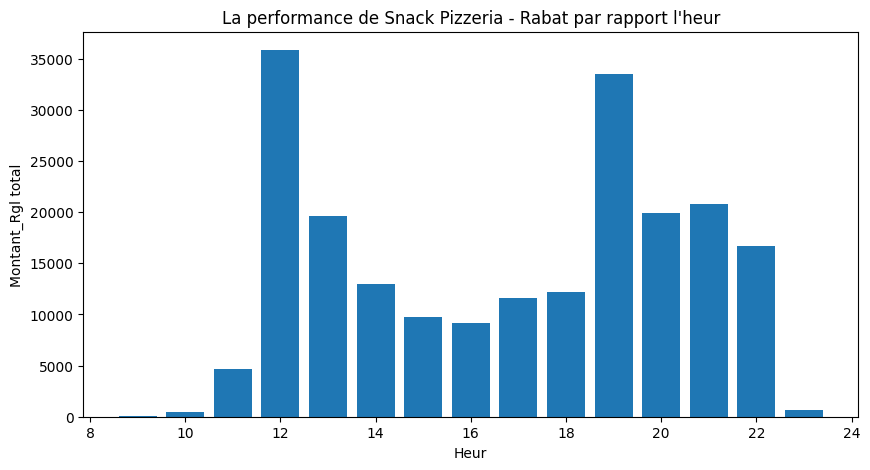

In [316]:
# Initialiser un dictionnaire pour stocker les données de chaque restaurant par heure
data_place_global = {}

# Grouper les données par heure et par restaurant, en sommant les montants de règlement
place_and_heure = data.groupby([data.index.hour, 'Restaurant'])['Montant_Rgl'].sum().reset_index()

for place in place_and_heure['Restaurant'].unique():
    # Filtrer les données pour le restaurant courant
    data_places = place_and_heure[place_and_heure['Restaurant'] == place]
    
    # Trier les données par montant de règlement de manière décroissante
    data_places = data_places.sort_values(by='Montant_Rgl', ascending=False)
    
    # Supprimer la colonne 'Restaurant' pour garder uniquement les heures et les montants
    data_places = data_places.drop(['Restaurant'], axis=1)
    
    # Ajouter les données filtrées au dictionnaire
    data_place_global[place] = data_places

# Créer un graphique à barres avec les heures et les montants correspondants
for name, df in data_place_global.items():
    plt.figure(figsize=(10, 5))
    bars = plt.bar(df['Date_heure_Règlement'], df['Montant_Rgl'])
    plt.title(f'La performance de {name} par rapport l\'heur')
    plt.xlabel('Heur')
    plt.ylabel('Montant_Rgl total')
plt.show()


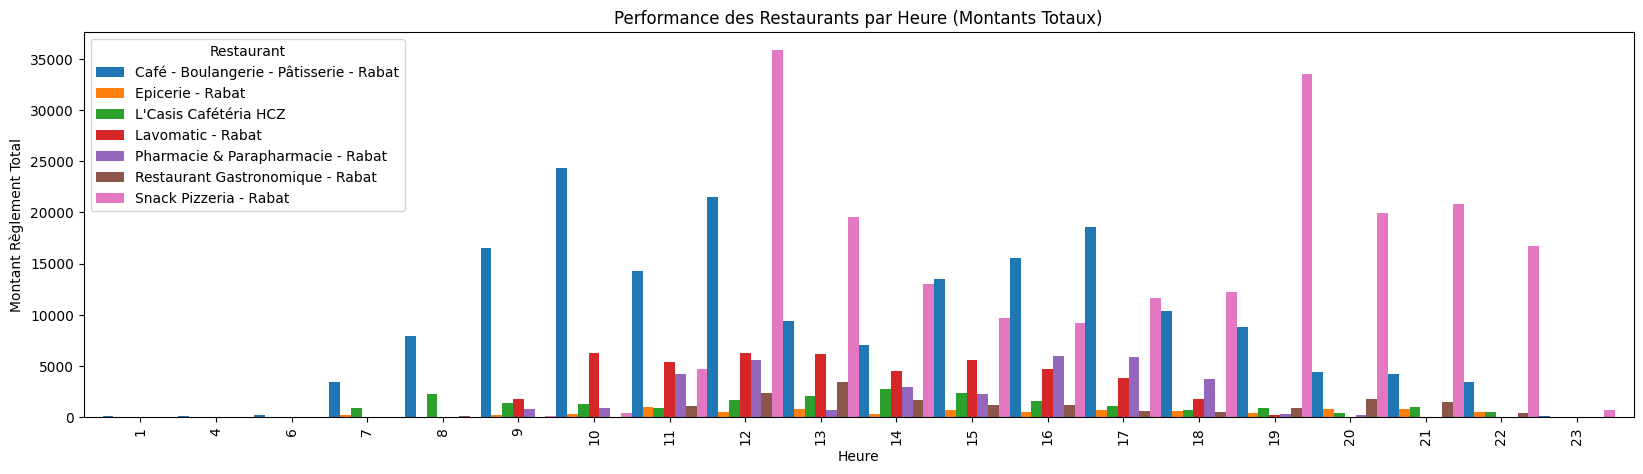

In [317]:
################# a tester 
# Grouper les données par heure et restaurant, et calculer la somme des montants
total_per_hour = data.groupby([data.index.hour, 'Restaurant'])['Montant_Rgl'].sum().reset_index()

# Pivotement du DataFrame pour obtenir les heures comme index et les restaurants comme colonnes
pivot_table = total_per_hour.pivot(index='Date_heure_Règlement', columns='Restaurant', values='Montant_Rgl').fillna(0)

# Créer un graphique à barres empilées pour les montants par heure
plt.figure(figsize=(20, 5))
pivot_table.plot(kind='bar', ax=plt.gca() , width=1, color=colors)
plt.title('Performance des Restaurants par Heure (Montants Totaux)')
plt.xlabel('Heure')
plt.ylabel('Montant Règlement Total')
plt.show()



## Tache 7 : Détection des anomalies (outliers) :

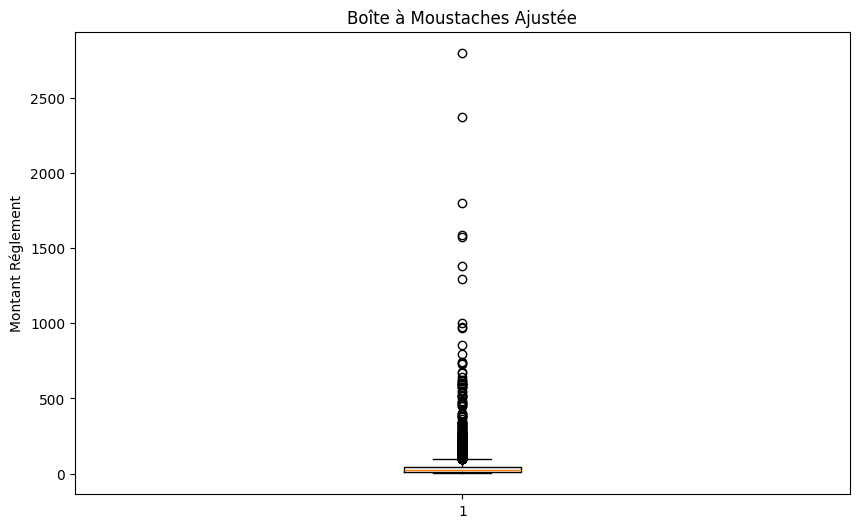

In [318]:
plt.figure(figsize=(10, 6))  

# Crée un boxplot pour la colonne 'Montant_Rgl'
plt.boxplot(data['Montant_Rgl'])
plt.title("Boîte à Moustaches Ajustée")
plt.ylabel("Montant Réglement")
plt.show()

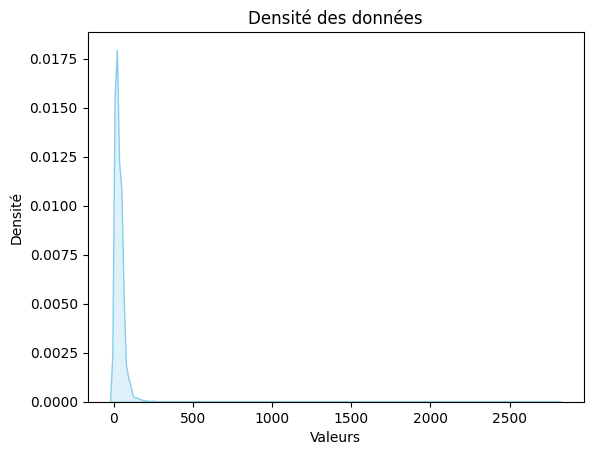

In [319]:
# Tracer la densité des données avec une couleur de remplissage
sns.kdeplot(data['Montant_Rgl'], fill=True, color='skyblue')

plt.title("Densité des données")
plt.xlabel("Valeurs")
plt.ylabel("Densité")
plt.show()

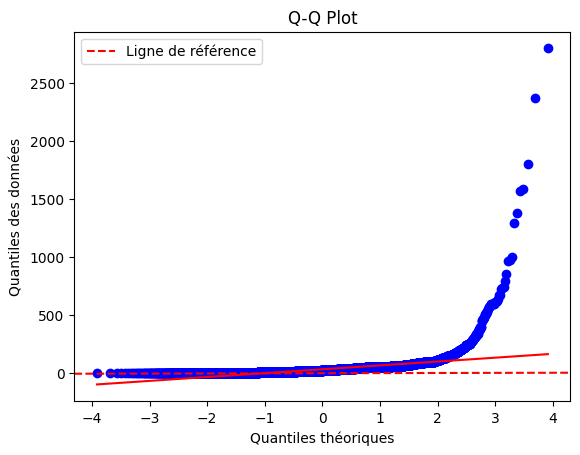

In [320]:
# Création du Q-Q Plot pour vérifier la normalité des données
stats.probplot(data['Montant_Rgl'], dist="norm", plot=plt)

plt.title("Q-Q Plot")
plt.xlabel("Quantiles théoriques")
plt.ylabel("Quantiles des données")
plt.axline((0, 0), slope=1, color='red', linestyle='--', label='Ligne de référence')  # Ligne de référence
plt.legend()
plt.show()

In [321]:
# Calcul des quantiles Q1 et Q3
q1 = data['Montant_Rgl'].quantile(0.25)  # Premier quartile
q3 = data['Montant_Rgl'].quantile(0.75)  # Troisième quartile

# Calcul de l'Intervalle Interquartile (IQR)
IQR = q3 - q1

# Définition des limites inférieure et supérieure pour détecter les anomalies
Limit_inf = q1 - 2.5 * IQR  
Limit_Sup = q3 + 2.5 * IQR   

print(f'La plage acceptable des valeurs est [{Limit_inf}, {Limit_Sup}]')

La plage acceptable des valeurs est [-77.5, 132.5]


In [322]:
# Détection des valeurs aberrantes (outliers) selon les limites définies par l'IQR
outliers_IQR = data[(data['Montant_Rgl'] < Limit_inf) | (data['Montant_Rgl'] > Limit_Sup)]

# Affichage des valeurs aberrantes détectées
outliers_IQR

,Montant_Rgl,Montant_Versé,Montant_Rst,ID_Client,Client,ID_CartePP,Bénéficiaire_CPP,Solde_CPP,ID_Restaurant,Restaurant,ID_User,Prenom User
Date_heure_Règlement,,,,,,,,,,,,
2024-02-22 18:50:52,971.572010,971.572021,-1.144409e-05,CLT10002,CLIENT CARTE PRÉPAYÉE,CND_UA00032621/2023,RIFAI,2600.14,RST10006,Pharmacie & Parapharmacie - Rabat,USR10026,Kawtar
2024-02-27 12:32:42,200.000000,200.000000,0.000000e+00,CLT10002,CLIENT CARTE PRÉPAYÉE,6632395296331911,DOUDOUH,542.50,RST10010,Lavomatic - Rabat,USR10022,Fadwa
2024-02-29 14:50:54,180.000000,180.000000,0.000000e+00,NaN,NaN,1425863115513158,BOUICHENADE,1901.80,RST10003,Snack Pizzeria - Rabat,USR10001,Ayoub
2024-01-04 15:27:01,180.000000,180.000000,0.000000e+00,CLT10002,CLIENT CARTE PRÉPAYÉE,9516588571382149,AHMED SALEM,300.00,RST10010,Lavomatic - Rabat,USR10022,Fadwa
2024-01-19 13:22:57,150.000000,150.000000,0.000000e+00,CLT10001,CLIENT AU COMPTANT,1425863115513158,BOUICHENADE,226.30,RST10005,Café - Boulangerie - Pâtisserie - Rabat,USR10004,Hamza
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-23 16:09:59,134.000000,134.000000,0.000000e+00,CLT10001,CLIENT AU COMPTANT,3592789955996396,MOUSTAFI,1484.00,RST10014,Epicerie - Rabat,USR10029,Moncef
2024-08-26 13:44:34,159.000000,159.000000,0.000000e+00,NaN,NaN,9223555526483183,SADIQ,1966.00,RST10003,Snack Pizzeria - Rabat,USR10008,Souhail
2024-08-28 11:30:16,134.500000,134.500000,0.000000e+00,CLT10001,CLIENT AU COMPTANT,2928133427249849,AKDI,1784.50,RST10014,Epicerie - Rabat,USR10030,Abdelkrim


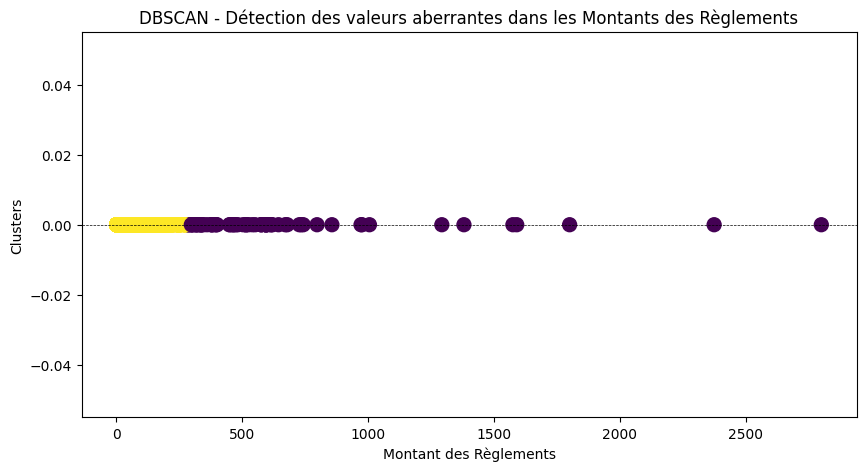

In [323]:
eps = 59.042239 ## la distance euclidien entre les points 
min_samples = 100 # Nombre minimum de points pour un cluster

# Appliquer DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
data['Cluster'] = dbscan.fit_predict(data[['Montant_Rgl']])

# Identifier les valeurs aberrantes (clusters étiquetés -1)
outliers_DBSCAN = data[data['Cluster'] == -1]

# Visualiser les résultats
plt.figure(figsize=(10, 5))
plt.scatter(data['Montant_Rgl'], np.zeros_like(data['Montant_Rgl']), c=data['Cluster'], cmap='viridis', s=100)
plt.title('DBSCAN - Détection des valeurs aberrantes dans les Montants des Règlements')
plt.xlabel('Montant des Règlements')
plt.ylabel('Clusters')
plt.axhline(0, color='black', linewidth=0.5, ls='--')
plt.show()

In [324]:
outliers_DBSCAN

,Montant_Rgl,Montant_Versé,Montant_Rst,ID_Client,Client,ID_CartePP,Bénéficiaire_CPP,Solde_CPP,ID_Restaurant,Restaurant,ID_User,Prenom User,Cluster
Date_heure_Règlement,,,,,,,,,,,,,
2024-02-22 18:50:52,971.572010,971.572021,-1.144409e-05,CLT10002,CLIENT CARTE PRÉPAYÉE,CND_UA00032621/2023,RIFAI,2600.14,RST10006,Pharmacie & Parapharmacie - Rabat,USR10026,Kawtar,-1
2024-01-19 16:15:13,1589.951992,1589.952026,-3.433228e-05,CLT10002,CLIENT CARTE PRÉPAYÉE,CND_UA00032621/2023,RIFAI,2250.50,RST10006,Pharmacie & Parapharmacie - Rabat,USR10026,Kawtar,-1
2024-01-19 16:22:22,300.000000,300.000000,0.000000e+00,CLT10002,CLIENT CARTE PRÉPAYÉE,CND_UA00032621/2023,RIFAI,660.55,RST10006,Pharmacie & Parapharmacie - Rabat,USR10026,Kawtar,-1
2024-01-19 19:40:10,285.000000,285.000000,0.000000e+00,CLT10001,CLIENT AU COMPTANT,2759346313129471,CHAGH,2003.00,RST10004,Restaurant Gastronomique - Rabat,USR10002,Souhail,-1
2024-02-03 12:40:25,1574.750015,1574.750000,1.525879e-05,CLT10002,CLIENT CARTE PRÉPAYÉE,CND_UA00032621/2023,RIFAI,2674.50,RST10006,Pharmacie & Parapharmacie - Rabat,USR10026,Kawtar,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28 18:26:26,974.908005,974.908020,-1.525879e-05,CLT10002,CLIENT CARTE PRÉPAYÉE,CND_UA00030018/2022,EL YAAGOUBI,1521.21,RST10006,Pharmacie & Parapharmacie - Rabat,USR10028,Mourad,-1
2024-06-28 18:30:06,346.000000,346.000000,0.000000e+00,CLT10002,CLIENT CARTE PRÉPAYÉE,CND_UA00030018/2022,EL YAAGOUBI,546.30,RST10006,Pharmacie & Parapharmacie - Rabat,USR10028,Mourad,-1
2024-07-19 13:25:34,613.179993,613.179993,-2.273737e-13,CLT10002,CLIENT CARTE PRÉPAYÉE,CND_UA00032621/2023,RIFAI,618.12,RST10006,Pharmacie & Parapharmacie - Rabat,USR10028,Mourad,-1


In [325]:
# Regrouper les anomalies détectées par DBSCAN
outliers_group_DB = outliers_DBSCAN.groupby([outliers_DBSCAN.index.hour, 'Bénéficiaire_CPP', 'Restaurant']).size()

# Afficher le résultat
outliers_group_DB

Date_heure_Règlement  Bénéficiaire_CPP    Restaurant                             
9                     ZAABOUL             Pharmacie & Parapharmacie - Rabat          1
10                    HOUSNI              Café - Boulangerie - Pâtisserie - Rabat    2
                      RACHIDI SALAH       Café - Boulangerie - Pâtisserie - Rabat    1
                      RIFAI               Pharmacie & Parapharmacie - Rabat          1
11                    CHAGH               Pharmacie & Parapharmacie - Rabat          1
                                          Restaurant Gastronomique - Rabat           2
                      REGRAGUI            Pharmacie & Parapharmacie - Rabat          3
                      SELMANI             Pharmacie & Parapharmacie - Rabat          3
12                    BENJOUAD            Restaurant Gastronomique - Rabat           1
                      EL YAAGOUBI         Pharmacie & Parapharmacie - Rabat          2
                                          Restau

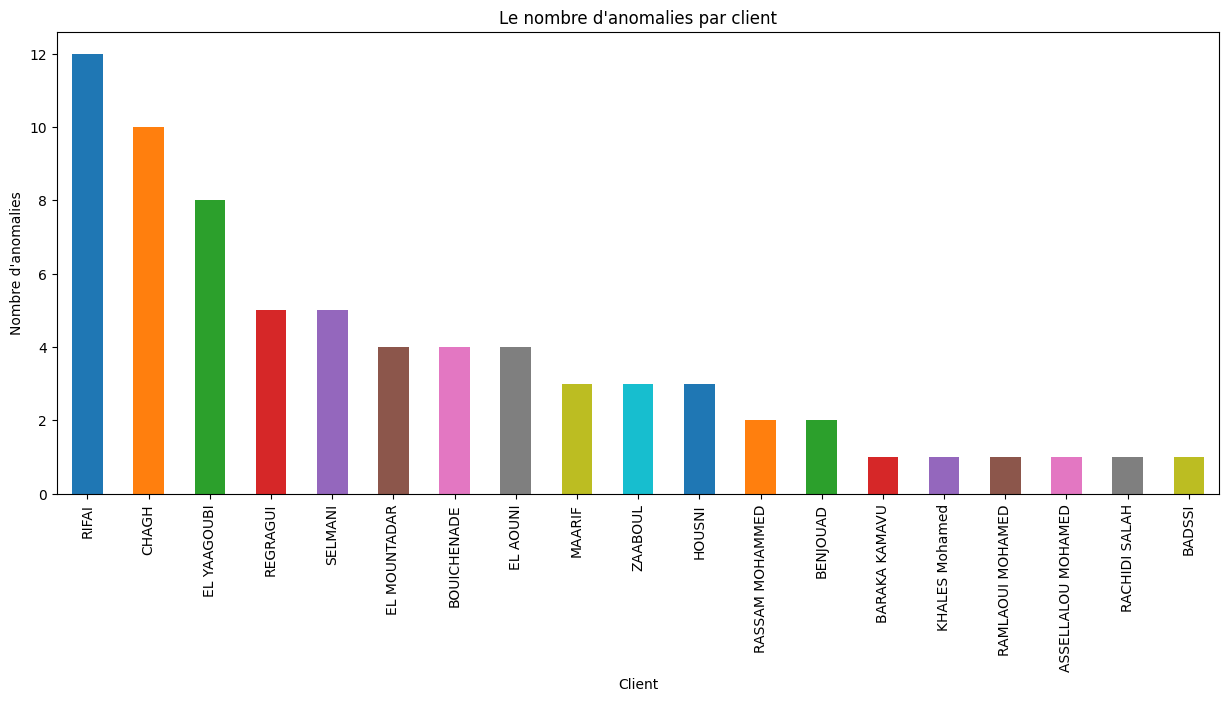

In [326]:
# Comptage des anomalies par client
outliers_client = outliers_DBSCAN['Bénéficiaire_CPP'].value_counts()

# Création d'un graphique à barres
plt.figure(figsize=(15, 6))
outliers_client.plot(kind='bar', color=colors)
plt.title('Le nombre d\'anomalies par client')
plt.xlabel('Client')
plt.ylabel('Nombre d\'anomalies')
plt.show()


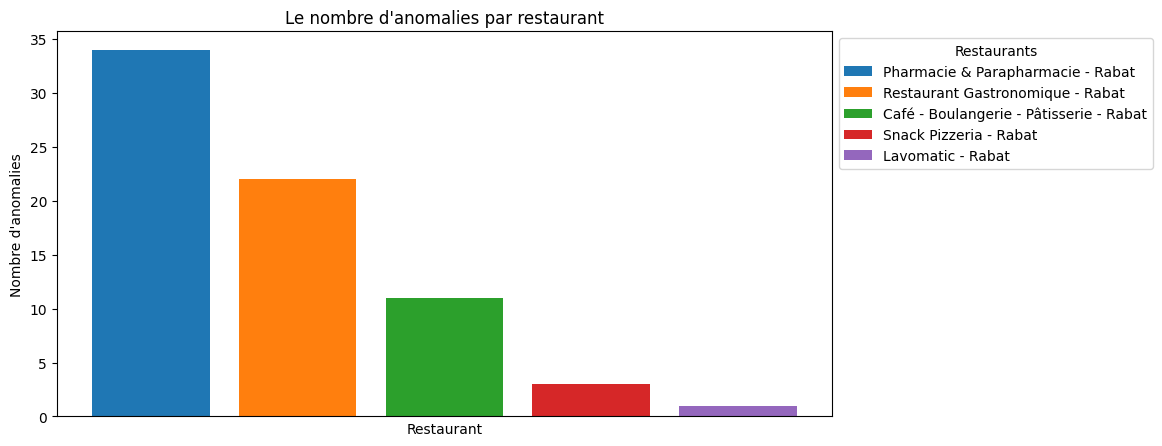

In [327]:
####graphiques du restaurant avec le plus d'anomalies.

# Comptage des anomalies par restaurant
outliers_resto = outliers_DBSCAN['Restaurant'].value_counts()

# Création du graphique en barres
plt.figure(figsize=(10,5))
bars = plt.bar(outliers_resto.index, outliers_resto.values, color=colors)
plt.title("Le nombre d'anomalies par restaurant")
plt.xlabel("Restaurant")
plt.ylabel("Nombre d'anomalies")
plt.xticks([])
plt.legend(bars, outliers_resto.index, title='Restaurants', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

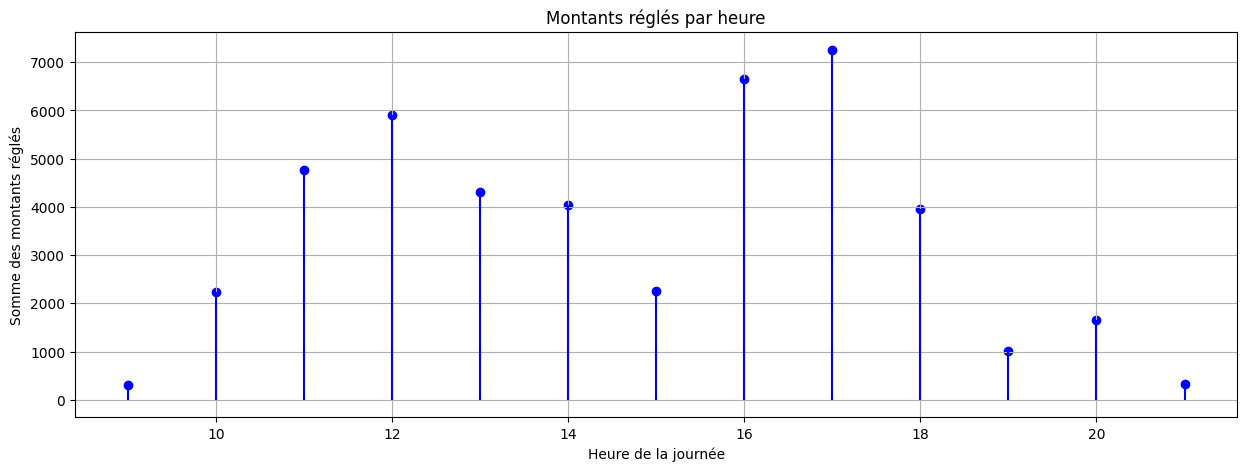

In [328]:
# Regroupement des anomalies par heure et somme des montants réglés
outliers_DB_grp_H = outliers_DBSCAN.groupby(outliers_DBSCAN.index.hour)['Montant_Rgl'].sum().reset_index()

# Création d'un graphique
plt.figure(figsize=(15, 5))
plt.scatter(outliers_DB_grp_H[outliers_DB_grp_H.columns[0]], outliers_DB_grp_H['Montant_Rgl'], color='blue')
plt.vlines(x=outliers_DB_grp_H[outliers_DB_grp_H.columns[0]], ymin=0, ymax=outliers_DB_grp_H['Montant_Rgl'], color='blue')
plt.title("Montants réglés par heure")
plt.xlabel("Heure de la journée")
plt.ylabel("Somme des montants réglés")
plt.grid()
plt.show()


## Tache 8 : Analyse des performances des caissiers :

In [329]:
# Regrouper les données par 'ID_User' et compter le nombre d'occurrences de chaque 'Prenom User'
caissier_data = data.groupby('ID_User')['Prenom User'].value_counts().reset_index()

# Affichage du DataFrame résultant
caissier_data

,ID_User,Prenom User,count
0,USR10001,Ayoub,797
1,USR10002,Souhail,1963
2,USR10003,Soundoss,3581
3,USR10004,Hamza,4158
4,USR10008,Souhail,2348
5,USR10022,Fadwa,641
6,USR10023,Abdelkarim,515
7,USR10024,Morad,361
8,USR10026,Kawtar,26
9,USR10027,Ayman,235


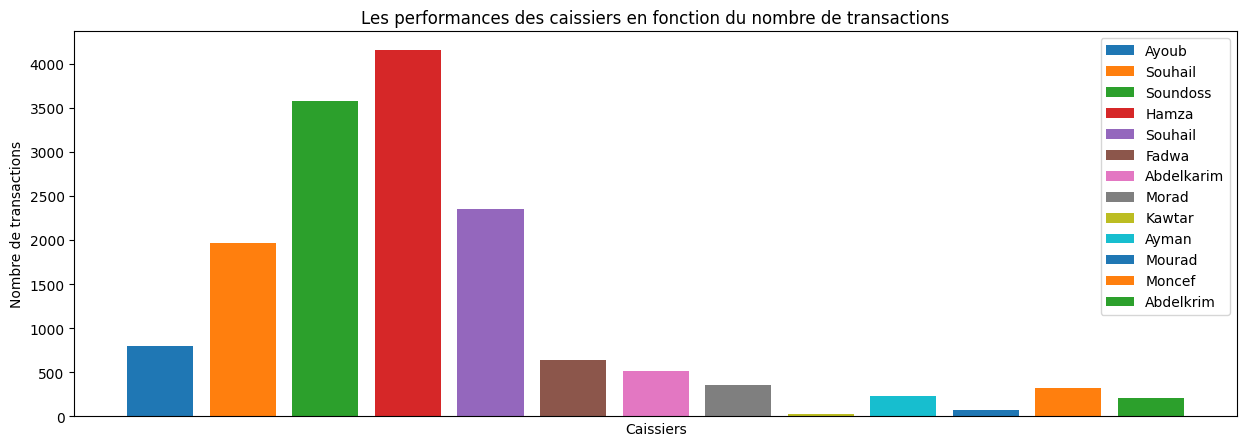

In [330]:
# Création d'une figure avec une taille spécifiée pour le graphique
plt.figure(figsize=(15,5))

# Création d'un graphique en barres montrant le nombre de transactions par chaque caissier
plt.bar(caissier_data['ID_User'], caissier_data['count'], 
        label=caissier_data['Prenom User'], color=colors)

plt.title('Les performances des caissiers en fonction du nombre de transactions')
plt.xlabel('Caissiers')
plt.ylabel('Nombre de transactions')
plt.xticks([])
plt.legend()
plt.show()

In [331]:
# Regrouper les données par 'ID_User' et calculer le montant total des transactions réglées
caissier_montant_total = data.groupby('ID_User')['Montant_Rgl'].sum().reset_index()

# Affichage du DataFrame résultant
caissier_montant_total

,ID_User,Montant_Rgl
0,USR10001,38756.000000
1,USR10002,92377.500000
2,USR10003,81483.000000
3,USR10004,96208.000000
4,USR10008,98934.000000
5,USR10022,46274.139999
6,USR10023,9759.500000
7,USR10024,7230.000000
8,USR10026,8923.107556
9,USR10027,4582.000000


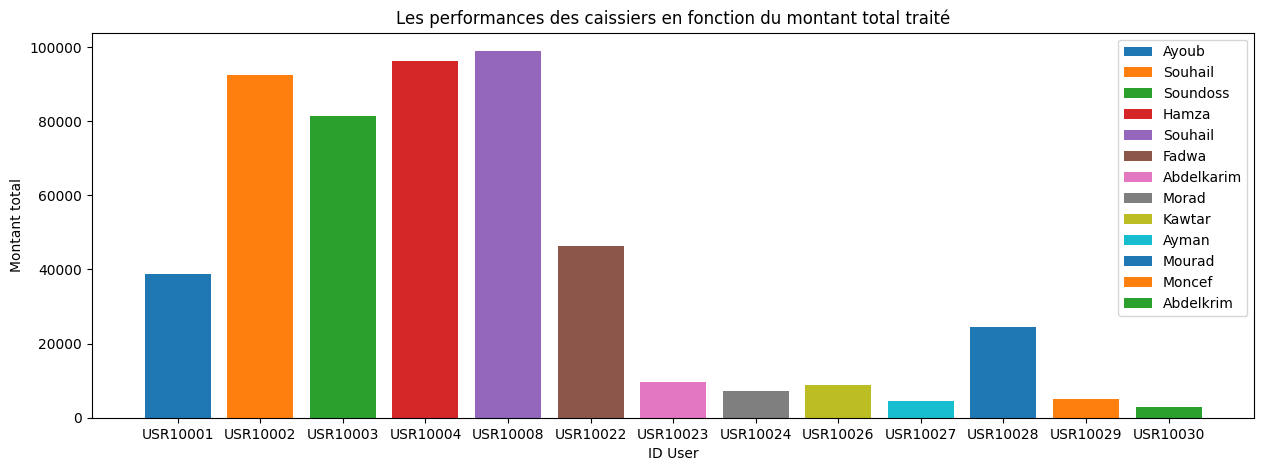

In [332]:
# Création d'une figure avec une taille spécifiée pour le graphique
plt.figure(figsize=(15,5))

# Création d'un graphique en barres montrant le montant total traité par chaque caissier
plt.bar(caissier_montant_total['ID_User'], caissier_montant_total['Montant_Rgl'], 
        label=caissier_data['Prenom User'], color=colors)

plt.title('Les performances des caissiers en fonction du montant total traité')
plt.xlabel('ID User')
plt.ylabel('Montant total')
plt.legend()
plt.show()

In [333]:
# Groupement des anomalies par ID d'utilisateur et prénom
outliers_client_caissier = outliers_DBSCAN.groupby(['ID_User', 'Prenom User'])['Bénéficiaire_CPP'].size().reset_index()

outliers_client_caissier

,ID_User,Prenom User,Bénéficiaire_CPP
0,USR10001,Ayoub,12
1,USR10002,Souhail,6
2,USR10003,Soundoss,3
3,USR10004,Hamza,7
4,USR10008,Souhail,8
5,USR10022,Fadwa,1
6,USR10026,Kawtar,7
7,USR10028,Mourad,27


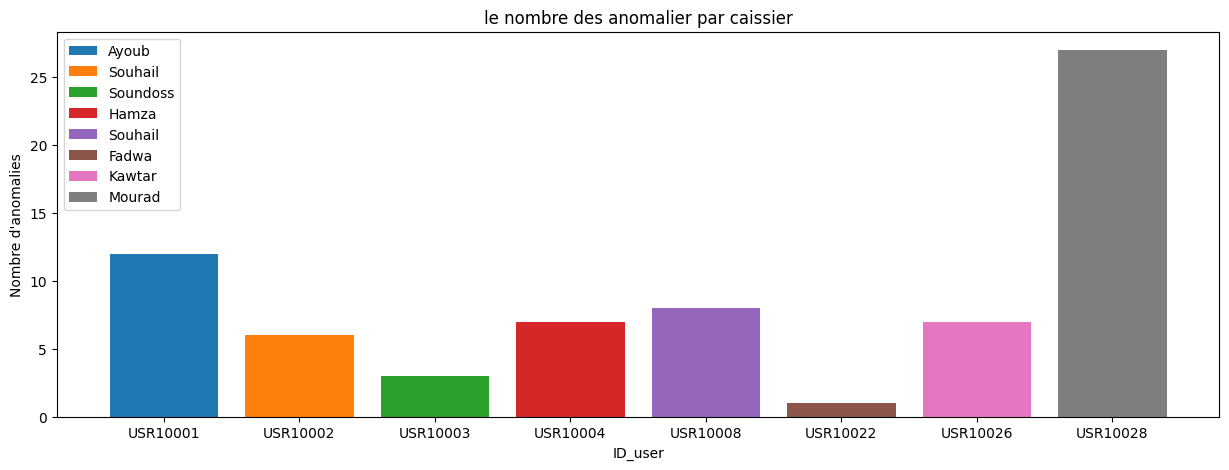

In [334]:
#les performances des caissiers en fonction du montant total traité
plt.figure(figsize=(15,5))
plt.bar(outliers_client_caissier['ID_User'] ,outliers_client_caissier['Bénéficiaire_CPP'] , label = outliers_client_caissier['Prenom User'] , color=colors )
plt.title('le nombre des anomalier par caissier')
plt.xlabel('ID_user')
plt.ylabel('Nombre d\'anomalies')
plt.legend()
plt.show()

In [335]:
# Calcul du nombre d'anomalies par caissier pour chaque heure de la journée
outlier_caissier_time = outliers_DBSCAN.groupby(outliers_DBSCAN.index.hour)['ID_User'].size().reset_index()

outlier_caissier_time

,Date_heure_Règlement,ID_User
0,9,1
1,10,4
2,11,9
3,12,8
4,13,10
5,14,4
6,15,4
7,16,8
8,17,9
9,18,7


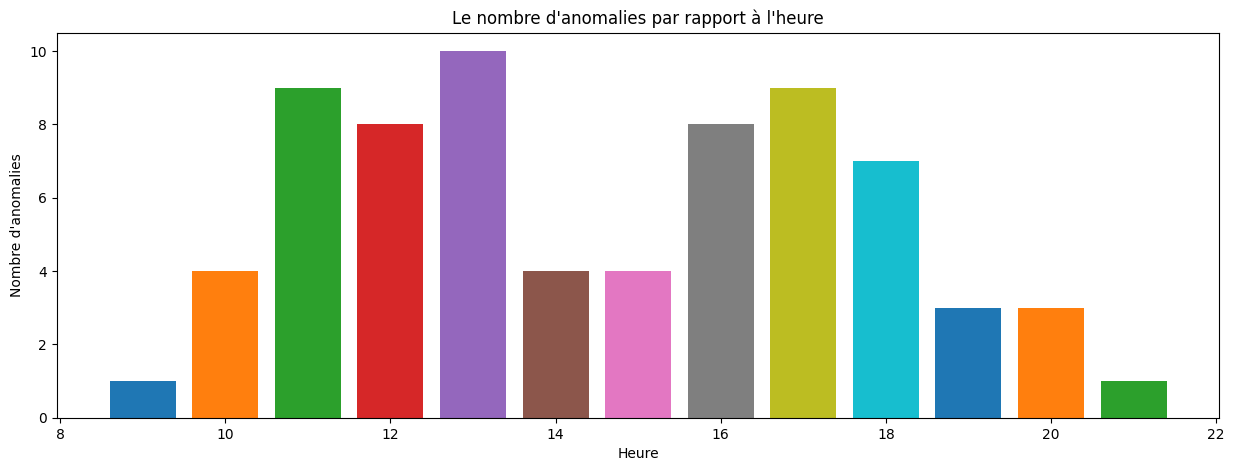

In [336]:
# Création d'une figure pour le graphique
plt.figure(figsize=(15, 5))

# Tracé des barres avec les heures en abscisse et le nombre d'anomalies en ordonnée
plt.bar(outlier_caissier_time['Date_heure_Règlement'], outlier_caissier_time['ID_User'], color=colors)
plt.title('Le nombre d\'anomalies par rapport à l\'heure')
plt.xlabel('Heure')
plt.ylabel('Nombre d\'anomalies')
plt.show()

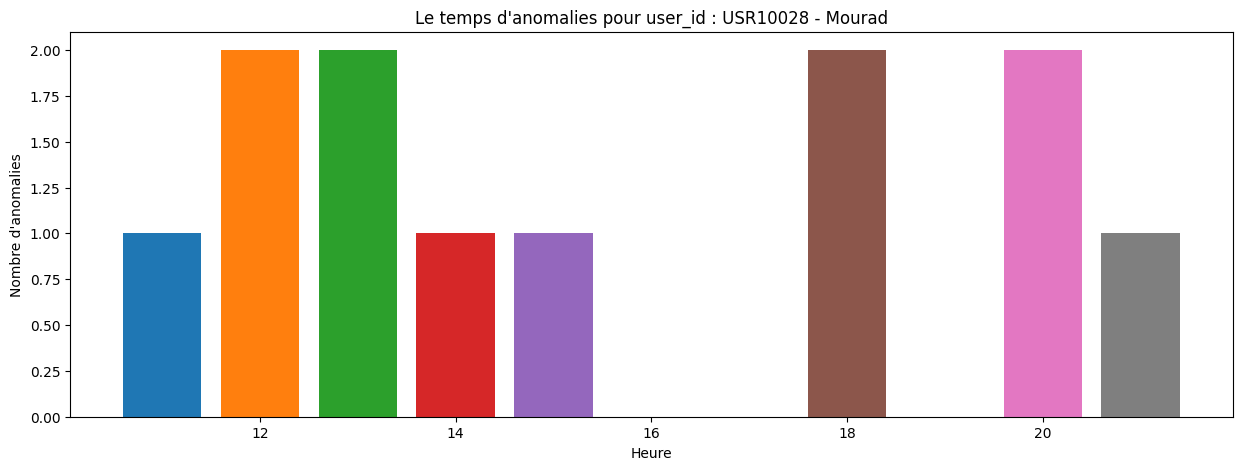

In [344]:
# Filtrer les données pour l'utilisateur avec l'ID 'USR10028'
data_USR10028 = outliers_DBSCAN[outliers_DBSCAN['ID_User'] == 'USR10001']

# Grouper les données filtrées par heure et compter le nombre d'occurrences d'ID_User
heur_grp_USR10028 = data_USR10028.groupby(data_USR10028.index.hour)['ID_User'].count().reset_index()

plt.figure(figsize=(15, 5))

# Créer un graphique à barres avec les heures et le nombre d'anomalies pour l'utilisateur 'USR10028'
plt.bar(heur_grp_USR10028['Date_heure_Règlement'], heur_grp_USR10028['ID_User'], color=colors)
plt.title('Le temps d\'anomalies pour user_id : USR10028 - Mourad')
plt.xlabel('Heure')
plt.ylabel('Nombre d\'anomalies')
plt.show()

## Tache 9 : Analyse de la corrélation :

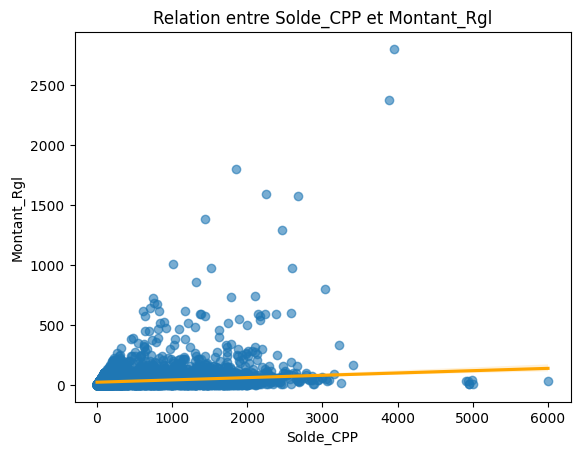

In [338]:
# Création d'un graphique de dispersion pour visualiser la relation entre le Solde_CPP et le Montant_Rgl
plt.scatter(data['Solde_CPP'], data['Montant_Rgl'], alpha=0.6)  # Trace les points de données

# Ajout d'une régression linéaire sur le graphique
sns.regplot(x='Solde_CPP', y='Montant_Rgl', data=data, scatter=False, color='orange')
plt.xlabel('Solde_CPP')  
plt.ylabel('Montant_Rgl')  
plt.title('Relation entre Solde_CPP et Montant_Rgl')
plt.show()

             Solde_CPP  Montant_Rgl
Solde_CPP     1.000000     0.193292
Montant_Rgl   0.193292     1.000000


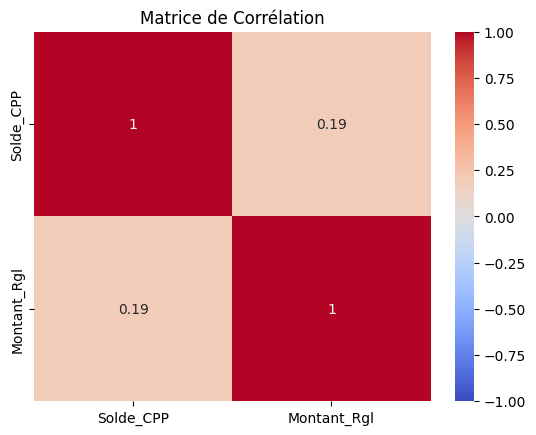

In [339]:
corr_matrix = data[['Solde_CPP', 'Montant_Rgl']].corr()

# Afficher la matrice de corrélation
print(corr_matrix)

# Visualisation avec une heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Afficher la heatmap
plt.title('Matrice de Corrélation')
plt.show()

In [340]:
# Calculer le solde total pour chaque bénéficiaire
solde_CPP = data.groupby('Bénéficiaire_CPP')['Solde_CPP'].sum().reset_index()  

# Calculer le montant total réglé pour chaque bénéficiaire
dep_total = data.groupby('Bénéficiaire_CPP')['Montant_Rgl'].sum().reset_index() 

# Fusionner les deux DataFrames sur la colonne 'Bénéficiaire_CPP'
merge_data = pd.merge(solde_CPP, dep_total, on='Bénéficiaire_CPP')

merge_data  

,Bénéficiaire_CPP,Solde_CPP,Montant_Rgl
0,AABID,729.00,259.500000
1,AABIL,58035.30,2824.900002
2,AARAB,142612.50,7205.000000
3,AARIBECHE,130.50,28.000000
4,AAYLA,914.09,184.625000
...,...,...,...
850,meryem el,369.50,108.000000
851,nassri,183.76,33.740000
852,nouhaila alaoui ait,159.00,36.000000
853,rhazal,295.02,30.000000


In [341]:
# Calculer la corrélation de Spearman entre 'Solde_CPP' et 'Montant_Rgl'
correlation_spearman = merge_data['Solde_CPP'].corr(merge_data['Montant_Rgl'], method='spearman')

print("Corrélation de Spearman:", correlation_spearman)

Corrélation de Spearman: 0.8915419562809276


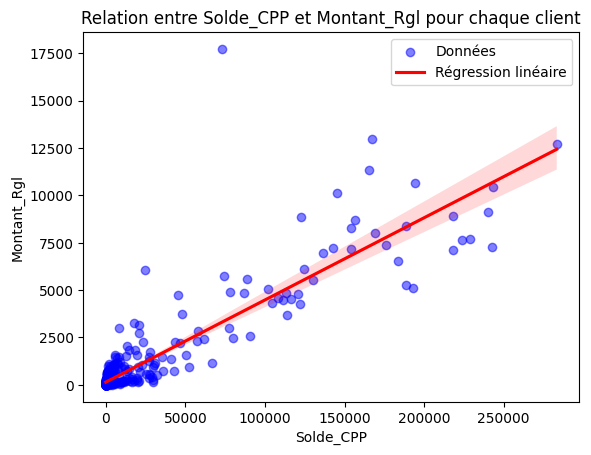

In [342]:
# Création d'un nuage de points pour visualiser la relation entre Solde_CPP et Montant_Rgl
plt.scatter(merge_data['Solde_CPP'], merge_data['Montant_Rgl'], color='blue', alpha=0.5, label='Données')

# Ajout d'une régression linéaire
sns.regplot(x='Solde_CPP', y='Montant_Rgl', data=merge_data, scatter=False, color='red', label='Régression linéaire')
plt.xlabel('Solde_CPP')
plt.ylabel('Montant_Rgl')
plt.title('Relation entre Solde_CPP et Montant_Rgl pour chaque client')
plt.legend()
plt.show()

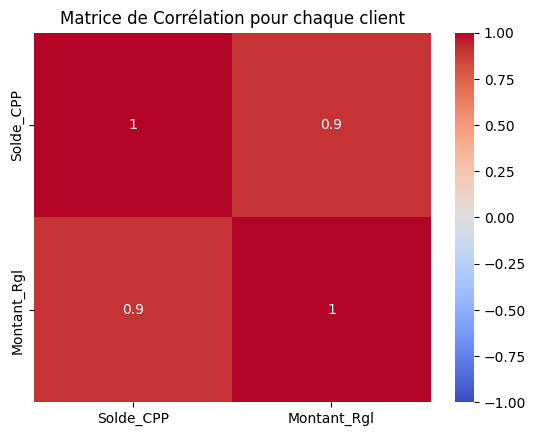

In [343]:
corr_matrix = merge_data[['Solde_CPP', 'Montant_Rgl']].corr()
# Visualisation avec une heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Afficher la heatmap
plt.title('Matrice de Corrélation pour chaque client')
plt.show()